# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

#### <font color='#473C8B'>Общая информация</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# Прочитаем файл формата csv. При первой попытке это сделать, выяснилось, что в качестве
# разделителя столбцов в исходном файле используется знак табуляции. Добавим соответствующий
# параметр при вызове метода read_csv

try:
    df = df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    try:
        df = pd.read_csv('real_estate_data.csv', sep='\t')
    except: 
        df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

# Сделаем так, чтобы отображались все столбцы таблицы    
pd.set_option('display.max_columns', 30)
    
# Выведем на экран общую информацию и 5 случайных строк для ознакомления с имеющимися полями таблицы:    
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1252,7,3200000.0,41.7,2017-10-13T00:00:00,1,2.56,12.0,19.9,12,NaN,False,False,10.2,2.0,Санкт-Петербург,32785.0,13784.0,0.0,NaN,0.0,NaN,102.0
11341,17,5900000.0,98.1,2017-07-23T00:00:00,4,NaN,10.0,60.8,9,NaN,False,False,8.3,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,245.0
15220,3,2300000.0,31.7,2017-05-10T00:00:00,1,2.50,6.0,15.2,3,False,False,False,9.7,0.0,посёлок Шушары,18363.0,24165.0,0.0,NaN,0.0,NaN,49.0
2768,10,3600000.0,31.0,2016-05-20T00:00:00,1,2.50,3.0,17.0,3,NaN,False,False,5.5,0.0,посёлок Стрельна,27909.0,22953.0,2.0,156.0,3.0,489.0,105.0
10929,13,9610305.0,61.0,2017-08-23T00:00:00,1,NaN,9.0,NaN,5,NaN,False,False,NaN,NaN,Санкт-Петербург,31170.0,6498.0,1.0,1057.0,1.0,563.0,NaN


Полученные данные содержат <b>23 699</b> строк. Есть пропуски в значениях, но основная информация: <i>общая площадь, дата публикации, цена на момент снятия с публикации, количество комнат</i> заполнены. 

#### <font color='#473C8B'>Гистограммы значений количественных параметров</font>

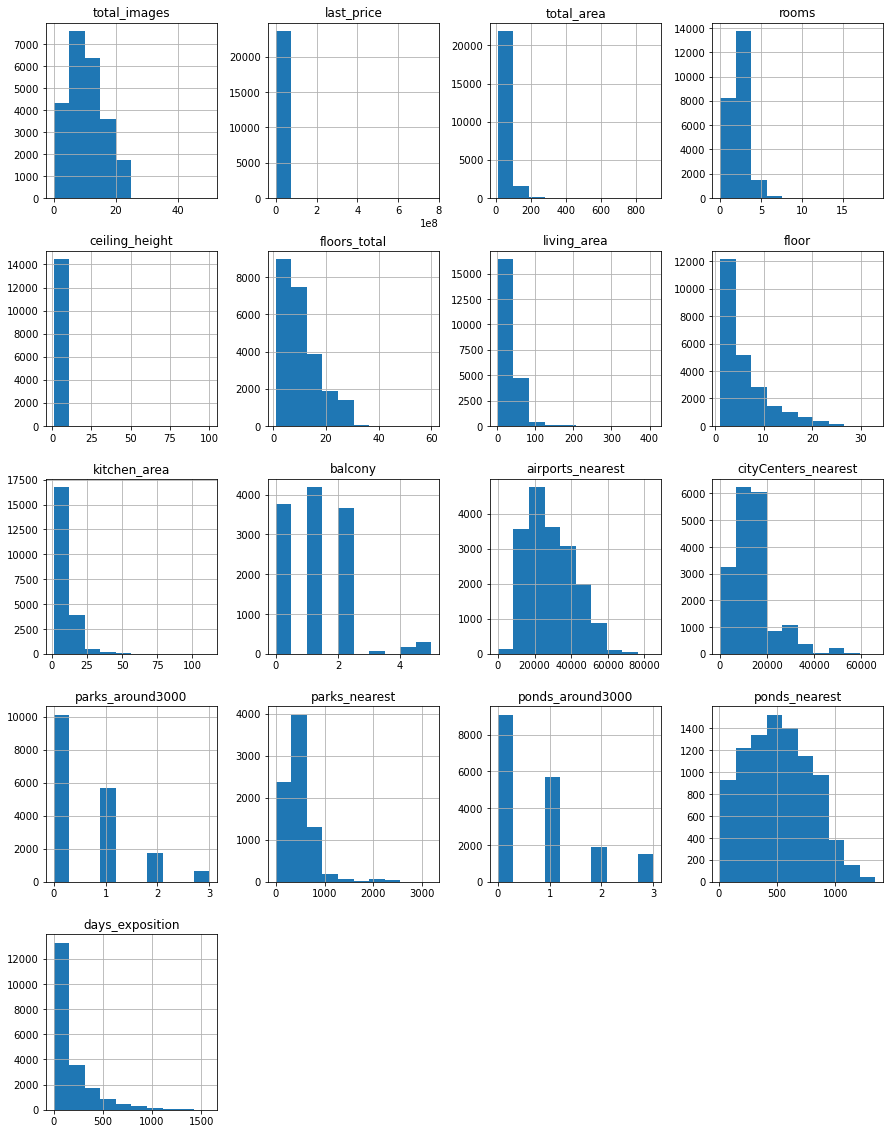

In [2]:
# Построим гистограммы для всех столбцов с числовыми данными в датафрейме
df.hist(figsize=(15, 20))
plt.show()

#### <font color='#473C8B'>Цели исследования</font>

Итак, нам предстоит найти от каких фактов в большей степени зависит цена на недвижимость. А также от чего может зависеть как быстро продаётся жильё. А именно:    
- от общей площади, в том числе от жилой площади и площади кухни;    
- от этажа, особенно если это первый или последний этаж;    
- а может быть от количества балконов и высоты потолков.   
   
Также в нашем распоряжении будет следующая информация:    
- дата публикации объявления;
- район или населённый пункт;
- прочая информация об объекте недвижимости - апартаменты, студия или квартира со свободной планировкой;
- количество фотографий;
- удалённость от центра и аэропорта;
- близость парков и водоёмов.

#### <font color='#473C8B'>Ход исследования:</font>

- провести первичную обработку данных - там, где это возможно заменить пропущенные значения, удалить аномальные, найти дубликаты;
- изучить все данные и их распределения, определить особенности;
- проверить все имеющиеся параметры - как и насколько зависит от каждого из них цена на недвижимость;
- проанализировать данные о количестве дней, в течение которых объявления были опубликованы, попытаться найти возможные причины "долгих" продаж;
- выяснить, в какие из населенных пунктов с самым большим (по количеству объявлений) рынком недвижимости имеют также и самые высокие цены на жильё;
- для квартир из Санкт-Петербурга найти как зависит цена от удалённости от центра города, рассчитав цену за 1 км расстояния;
- выбрать параметры, которые являются определяющими для цены на недвижимость, чтобы рекомендовать заказчику осуществлять проверку указанной в объявлении информации.
</div>
<hr>

### Предобработка данных

#### <font color='#473C8B'>Поиск и замена пропущенных и аномальных значений</font>

Найдём в каких полях таблицы имеются пропущенные значения.

In [3]:
display(df.isna().sum().to_frame().style.background_gradient('Blues'))

,0
total_images,0
last_price,0
total_area,0
first_day_exposition,0
rooms,0
ceiling_height,9195
floors_total,86
living_area,1903
floor,0
is_apartment,20924


##### Пропущенные и аномальные значения площади и количества комнат 
<i>Общая площадь и количество комнат</i> указаны для всех объектов недвижимости. Но пропущенные значения встречаются в размерах <i>жилой площади и кухни</i>. При публикации объявлений, эти значения клиенты могли попросту не указать. Можно заполнить пропуски медианами по всем квартирам похожей общей площадью.
 
Чтобы это осуществить, проверим сначала, нет ли ошибок в данных и аномально больших значений. Судя по гистограммам, такие значения наверняка найдутся. Посмотрим, что они из себя представляют

In [4]:
# найдём минимальные и максимальные значения указанных площадей, а также количества комнат
display(df[['total_area', 'living_area', 'kitchen_area', 'rooms']].agg(['min', 'max']))

,total_area,living_area,kitchen_area,rooms
min,12.0,2.0,1.3,0
max,900.0,409.7,112.0,19


<i><b>1)</b> Проверим самые большие и самые маленькие по размеру квартиры</i>

In [5]:
# познакомимся с самыми огромными квартирами
print('Объектов недвижимости с площадью больше 250 кв.м:\033[1m', 
      df.query("total_area > 250")["total_area"].count(),'\033[0m')

display(df.sort_values(by='total_area', ascending=False).head())

Объектов недвижимости с площадью больше 250 кв.м: 112 


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19540,8,420000000.0,900.0,2017-12-06T00:00:00,12,2.8,25.0,409.7,25,NaN,False,False,112.0,NaN,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0
12859,20,140000000.0,631.2,2019-04-09T00:00:00,7,3.9,4.0,322.3,4,NaN,False,False,19.5,1.0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
3117,19,140000000.0,631.0,2019-03-30T00:00:00,7,NaN,5.0,NaN,5,NaN,False,False,60.0,NaN,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
15651,20,300000000.0,618.0,2017-12-18T00:00:00,7,3.4,7.0,258.0,5,NaN,False,False,70.0,NaN,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0
5358,20,65000000.0,590.0,2019-02-14T00:00:00,15,3.5,6.0,409.0,3,NaN,False,False,100.0,NaN,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0


In [6]:
# самые маленькие по площади объекты
display(df.sort_values(by='total_area').head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19904,4,2400000.0,12.0,2017-07-19T00:00:00,1,2.55,5.0,10.0,2,NaN,False,False,NaN,NaN,Санкт-Петербург,21314.0,964.0,1.0,886.0,2.0,45.0,200.0
17961,3,1400000.0,13.0,2017-12-03T00:00:00,1,2.60,9.0,NaN,1,NaN,False,False,NaN,NaN,Санкт-Петербург,14350.0,15945.0,0.0,NaN,1.0,185.0,410.0
19546,3,1850000.0,13.0,2019-03-11T00:00:00,1,3.40,5.0,NaN,2,False,False,False,NaN,NaN,Санкт-Петербург,24915.0,5483.0,1.0,644.0,0.0,NaN,24.0
19807,0,3800000.0,13.0,2018-07-04T00:00:00,1,NaN,5.0,10.0,3,NaN,False,False,NaN,NaN,Санкт-Петербург,21302.0,1242.0,1.0,592.0,3.0,27.0,9.0
19558,2,1686000.0,13.2,2018-12-17T00:00:00,1,NaN,5.0,NaN,1,NaN,False,False,NaN,NaN,Санкт-Петербург,19891.0,4165.0,1.0,361.0,1.0,155.0,19.0


Похоже, в радиусе 6-7 км от центра города существует немало пентхаусов. Для многих из них указана и <i>жилая площадь, и площадь кухни, и количество комнат</i>. 

Что касается маленьких по площади объектов недвижимости - это могут быть, например, комнаты в коммунальных квартирах. Такие квартиры до сих пор существуют. Поэтому для большинства из них не указана площадь кухни. 

<i><b>2)</b> Проверим отсутствие комнат и недвижимость с максимальным количеством комнат</i>

In [7]:
print('Объектов недвижимости где 0 комнат:                     \033[1m', 
      df.query('rooms == 0')['rooms'].count(), '\033[0m')
print('Из них имеют свободную планировку или являются студиями:\033[1m', 
      df.query('rooms == 0 & (open_plan or studio)')['rooms'].count(), '\033[0m')

Объектов недвижимости где 0 комнат:                      197 
Из них имеют свободную планировку или являются студиями: 197 


Значит, все помещения, где 0 комнат - либо <i>студии</i>, либо квартиры со <i>свободной планировкой</i>.

In [8]:
# Проверим, нет ли слишком большого количества комнат в маленькой квартире
display(df.query('rooms > 11').sort_values(by='rooms', ascending=False))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
14498,6,32250000.0,374.6,2018-06-09T00:00:00,19,NaN,5.0,264.5,2,NaN,False,False,27.6,NaN,Санкт-Петербург,19497.0,3574.0,0.0,NaN,2.0,548.0,114.0
18848,6,28500000.0,270.0,2015-03-02T00:00:00,16,3.00,4.0,180.0,4,NaN,False,False,13.0,1.0,Санкт-Петербург,23575.0,4142.0,1.0,516.0,0.0,NaN,1365.0
5358,20,65000000.0,590.0,2019-02-14T00:00:00,15,3.50,6.0,409.0,3,NaN,False,False,100.0,NaN,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
866,5,25000000.0,363.0,2017-12-23T00:00:00,14,3.16,5.0,222.0,4,NaN,False,False,16.6,NaN,Санкт-Петербург,38076.0,7950.0,0.0,NaN,2.0,435.0,418.0
20829,6,28659000.0,245.4,2016-03-31T00:00:00,14,NaN,4.0,168.3,2,NaN,False,False,25.9,0.0,Санкт-Петербург,21104.0,2054.0,3.0,541.0,2.0,118.0,95.0
19540,8,420000000.0,900.0,2017-12-06T00:00:00,12,2.80,25.0,409.7,25,NaN,False,False,112.0,NaN,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


На первый взгляд, с площадью квартир и количеством комнат всё в порядке, ведь в Санкт-Петербурге много дворцов.


<i><b>3)</b> Проверим нет ли квартир, где на одну комнату приходится слишком маленькая площадь</i>

Так как в значениях жилой площади пока много пропусков, рассчитаем по общей площади. Т.е. сколько может занимать одна комната, если больше в квартире ничего нет.

In [9]:
print('Квартир где на одну комнату приходится меньше 12кв.м:\033[1m', 
      df[df['rooms']>0].query('total_area/rooms<12')['total_area'].count(), '\033[0m')
# найдём такую запись
display(df[df['rooms']>0].query('total_area/rooms<12'))

Квартир где на одну комнату приходится меньше 12кв.м: 4 


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
542,8,1750000.0,40.0,2016-04-28T00:00:00,5,NaN,5.0,28.6,1,False,False,False,5.0,0.0,Кингисепп,NaN,NaN,NaN,NaN,NaN,NaN,127.0
4077,10,3000000.0,20.0,2017-04-10T00:00:00,2,NaN,6.0,13.0,2,NaN,False,False,5.6,0.0,Санкт-Петербург,28450.0,6996.0,2.0,223.0,1.0,611.0,16.0
13034,11,2350000.0,42.0,2018-03-25T00:00:00,4,2.5,5.0,NaN,2,NaN,False,False,NaN,NaN,деревня Старая,NaN,NaN,NaN,NaN,NaN,NaN,44.0
20102,11,2350000.0,42.0,2018-02-15T00:00:00,4,2.6,5.0,NaN,2,NaN,False,False,NaN,NaN,деревня Колтуши,NaN,NaN,NaN,NaN,NaN,NaN,45.0


- в первой строке кто-то ошибся. Слишком много значений равных 5. Исправим количество комнат на 2. Думаю, им хватит. 
- во второй строке возможно посчитали кухню, как вторую комнату или в комнате организовали кухню. Исправим на 1. 
- третья и четвертая строки - мистическая квартира, которая находится сразу в двух деревнях. Заменим количество комнат на 2. 

In [10]:
# заменим значения по индексу
df.loc[[542, 13034, 20102],'rooms'] = 2
df.loc[4077,'rooms'] = 1

<i><b>4)</b> Проверим что жилая площадь меньше общей</i>

In [11]:
print('Сумма общей площади меньше суммы жилой и кухни:\033[1m', 
      df.query('total_area<living_area+kitchen_area')['total_area'].count(), '\033[0m')

display(df.query('total_area<living_area+kitchen_area').sample(5))

Сумма общей площади меньше суммы жилой и кухни: 64 


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5096,13,3500000.0,42.0,2019-01-25T00:00:00,1,3.0,12.0,34.0,1,NaN,False,False,9.0,NaN,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,48.0
9834,5,5950000.0,59.0,2018-03-17T00:00:00,2,2.5,18.0,53.0,9,NaN,False,False,8.6,1.0,Санкт-Петербург,23278.0,7223.0,1.0,655.0,2.0,938.0,150.0
601,12,5600000.0,53.7,2017-04-18T00:00:00,2,2.5,12.0,48.3,5,NaN,False,False,7.0,2.0,Санкт-Петербург,50477.0,13252.0,2.0,220.0,1.0,1250.0,167.0
19908,15,1800000.0,36.0,2016-05-18T00:00:00,1,NaN,5.0,28.0,4,False,False,False,9.0,0.0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,170.0
6559,10,4000000.0,26.0,2017-10-25T00:00:00,1,2.6,14.0,20.0,7,NaN,False,False,8.0,1.0,Санкт-Петербург,31832.0,8911.0,3.0,167.0,1.0,469.0,154.0


Похоже, что площадь кухни вошла в жилую. Можно вычесть площадь кухни из жилой площади, но надо проверить, не получим ли мы отрицательных чисел.

In [12]:
display(df.query('total_area<living_area+kitchen_area & living_area<kitchen_area'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1407,9,3250000.0,24.6,2018-06-29T00:00:00,1,NaN,25.0,18.0,16,NaN,False,False,18.2,NaN,Санкт-Петербург,35250.0,16414.0,0.0,NaN,1.0,400.0,96.0


Здесь ошибка сложнее. Не ясно что из чего нужно вычесть. Пожалуй, заменим на пустые значения и жилую площадь (слишком уж она большая, кухня уже не поместится), и площадь кухни. Затем мы эти пропуски заполним вместе с остальными. 

После этого можем вычесть площадь кухни из жилой площади для тех самых 64 записей таблицы.

In [13]:
# Заменим, обратившись к строке напрямую по индексу
df.loc[1407,['kitchen_area', 'living_area']] = np.nan

# вычтем площадь кухни из жилой в отобранных строках с помощью метода mask
df['living_area'] = df['living_area'].mask(df['total_area'] <  df['living_area'] + df['kitchen_area'], 
                                           df['living_area'] - df['kitchen_area'])

# проверим
# df.query('total_area<living_area+kitchen_area')['total_area'].count()

<i><b>5) </b>Замена пропущенных значений</i>

Заменим пропуски в полях <i>жилой площади и с площади кухни</i>. Будем считать, что и в квартирах-студиях, и в квартирах со свободной планировкой, и в апартаментах всё равно есть пространство для кухни и для жилой зоны. Сделаем следующим образом:
- разобьём все квартиры на группы в зависимости от площади;
-  в каждой группе найдём медианы значений для всех трёх площадей;
- рассчитаем какую долю от медианы общей площади занимают медианы жилой площади и кухни;
- заполним пропуски найденной долей от общей площади для каждой квартиры.

Если бы мы заполнили просто медианой по всем квартирам или даже медианой по квартирам одной категории, могло получиться так, что где-то опять оказалась общая площадь меньше жилой или другие "конфликты" этих значений.

In [14]:
# разделим все квартиры на 5 групп в зависимости от общей площади
# номер группы внесём в новый столбец датафрейма
df['total_area_group'] = pd.qcut(df['total_area'],q=5, labels=range(0,5))

# создадим для этих групп сводную таблицу с медианами площадей
df_area_pivot = df.pivot_table(index='total_area_group', 
                        values=['total_area', 'living_area', 'kitchen_area'], 
                        aggfunc='median')

# добавим в сводную таблицу столбцы, где рассчитаем какую долю от общей площади в квартире
# может занимать кухня и жилая площадь
df_area_pivot['kitchen_share'] = df_area_pivot['kitchen_area'] / df_area_pivot['total_area'] 
df_area_pivot['living_share'] = df_area_pivot['living_area'] / df_area_pivot['total_area'] 

display(df_area_pivot)

,kitchen_area,living_area,total_area,kitchen_share,living_share
total_area_group,,,,,
0,8.0,17.0,33.0,0.242424,0.515152
1,9.0,20.2,42.3,0.212766,0.477541
2,8.4,30.4,52.4,0.160305,0.580153
3,9.8,40.0,65.0,0.150769,0.615385
4,14.0,55.0,94.5,0.148148,0.582011


Наверное, можно было так не усложнять - но по этой табличке видно, что кухня в маленьких квартирах занимает чуть большую часть от общей площади, чем в больших. Для жилой площади такая зависимость не очевидна.

In [15]:
# произведём замену пропущенных значений в столбце с жилой площадью
for row_ind in df[df['living_area'].isna()].index:     # для всех строк датафрейма, где пропущено значение living_area
    # рассчитаем значение как долю от общей площади, результат округлим до одного знака после запятой
    df.loc[row_ind, 'living_area'] = round(
        df.loc[row_ind, 'total_area'] * 
        df_area_pivot.loc[df.loc[row_ind, 'total_area_group'], 'living_share'], 1)
    
# произведём замену пропущенных значений в столбце с площадью кухни
for row_ind in df[df['kitchen_area'].isna()].index:     # для всех строк датафрейма, где пропущено значение kitchen_area
    # рассчитаем значение как долю от общей площади, результат округлим до одного знака после запятой
    df.loc[row_ind, 'kitchen_area'] = round(
        df.loc[row_ind, 'total_area'] * 
        df_area_pivot.loc[df.loc[row_ind, 'total_area_group'], 'kitchen_share'], 
        1)
    
# проверим, что получилось
print('Количество пропущенных значений в столбцах с площадью:')
display(df[['total_area', 'living_area', 'kitchen_area']].isna().sum())

Количество пропущенных значений в столбцах с площадью:


total_area      0
living_area     0
kitchen_area    0
dtype: int64

##### Пропущенные значения высоты потолков 

Скорее всего, многие клиенты просто не указали <i>высоту потолков</i>, когда публиковали объявление. Чуть меньше половины от всех объектов недвижимости не содержат этой информации. Потолков высотой 0 не бывает, нулями заменить нельзя. Если заменять усреднёнными значениями, то в случае Санкт-Петербурга - сложно решить, по какому признаку определять высоту потолка. Например, если в доме 5 этажей, то это может быть как старое здание из центра города с высокими потолками, так и обычная "хрущёвка". В разных районах города существуют здания разной высоты. И даже в одном доме могут быть этажи с разной высотой потолков. Пожалуй, стоит пока оставить пропуски для этого столбца. 

In [16]:
display(df[["ceiling_height"]].agg(["min","median", "max"]))

print('Квартир с высотой потолка меньше 2 метров:     \033[1m', 
      df.query('ceiling_height <2')['ceiling_height'].count(), '\033[0m')

print('Квартир с высотой потолка  ровно 2 метра:     \033[1m', 
      df.query('ceiling_height == 2')['ceiling_height'].count(), '\033[0m')

print('Квартир с высотой потолка  от 5 до 20 метров: \033[1m',
     df.query('5 <= ceiling_height < 20')['ceiling_height'].count(), '\033[0m')

print('Квартир с высотой потолка  от 20 до 40 метров:\033[1m',
     df.query('20 <= ceiling_height < 40')['ceiling_height'].count(), '\033[0m')

print('Квартир с высотой потолка  выше 40 метров:     \033[1m',
     df.query('ceiling_height>=40')['ceiling_height'].count(), '\033[0m')

,ceiling_height
min,1.00
median,2.65
max,100.00


Квартир с высотой потолка меньше 2 метров:      3 
Квартир с высотой потолка  ровно 2 метра:      11 
Квартир с высотой потолка  от 5 до 20 метров:  14 
Квартир с высотой потолка  от 20 до 40 метров: 22 
Квартир с высотой потолка  выше 40 метров:      1 


<i><b>1) </b>Потолки ниже 2 метров</i>

In [17]:
display(df.query('ceiling_height < 2'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
5712,5,1500000.0,42.8,2017-08-14T00:00:00,2,1.20,2.0,27.5,1,NaN,False,False,5.20,NaN,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0,1
16934,5,4100000.0,40.0,2017-10-17T00:00:00,1,1.75,37.0,17.4,5,NaN,False,False,8.34,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0,1
22590,16,6000000.0,55.0,2018-10-31T00:00:00,2,1.00,12.0,32.4,7,NaN,False,False,10.00,NaN,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0,2


Аномально низких квартир оказалось всего 3. И мы можем их подробно "разглядеть". В первом случае - это квартира на первом этаже двухэтажного дома в посёлке. Маловероятно, что потолки всего 1.2 метра. Возможно, что продавец ошибся и написал "1.2" вместо "2.2" или даже вместо "3.2". 

Во второй строке квартира на пятом этаже 37-этажного здания. Такое здание действительно существует - самый высокий жилой дом города имеет 37 этажей. Но всё же это тоже похоже на ошибку.

Учитывая, что в столбце с высотой потолков очень много пропущенных данных, удалим три наших низких значения, не удаляя при этом всю строку.

In [18]:
# удалим данные о высоте потолка в самых низких квартирах
for i in df.query('1 <= ceiling_height < 2').index:
    df.loc[i, 'ceiling_height'] = np.nan 

<i><b>2) </b>Потолки высотой всего 2 метра</i>

Что касается квартир с высотой потолков в 2 метра, то они изредка встречаются как в наших данных, так и на самом деле. Такие квартиры есть, например, в центре Санкт-Петербурга в бывших доходных домах, на верхних этажах. В те далёкие годы это было самое дешёвое жильё.

<i><b>3) </b>Высота потолков от 20 до 40 метров</i>

Можно предположить, что был пропущен разделитель дробной части. И, например, для данных в 27 метров имелось ввиду 2.7м. Эти значения можно просто поделить на 10. 

In [19]:
# разделим на 10 высоту потолков, указанную в пределах от 20 до 40 метров
df['ceiling_height'] = df['ceiling_height'].mask(
    (20<=df['ceiling_height'])&(df['ceiling_height']<40), df['ceiling_height']/10)

<i><b>4) </b>На высоте птичьего полёта</i>

В последнюю строку судя по всему попала та самая квартира с аномальным значением в 100 метров. Данные о ней выведем на экран.

In [20]:
display(df.query('ceiling_height >= 40'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.0,5.0,14.0,5,True,False,False,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0,0


Жильё под открытым небом! Мы нашли однокомнатную квартиру на пятом этаже пятиэтажного дома. Площадью всего 25 кв.м. Но зато целых 5 балконов, высота потолков 100 метров, ни одной фотографии, и просуществовала она на рынке недвижимости всего 19 дней. Конечно, слишком много ошибок в одной строке. Но попробуем её сохранить. Удалим высоту потолка,  оставим пока количество балконов (с ними мы еще будем разбираться).

In [21]:
# удалим "высокий потолок"
df.loc[df['ceiling_height']==100, 'ceiling_height'] = np.nan

<i><b>5) </b>Квартиры с высотой потолков от 5 до 20 метров</i>

In [22]:
display(df.query('5 <= ceiling_height < 20'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
464,15,66571000.0,280.3,2015-06-11T00:00:00,6,5.2,8.0,159.5,7,NaN,False,False,21.1,0.0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0,4
1026,20,155000000.0,310.0,2018-10-12T00:00:00,5,5.3,3.0,190.0,3,NaN,False,False,63.0,2.0,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN,4
1053,13,550000.0,29.0,2018-02-01T00:00:00,1,5.0,3.0,14.9,1,False,False,False,7.0,NaN,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,6.0,0
1388,20,59800000.0,399.0,2015-01-21T00:00:00,5,5.6,6.0,232.2,6,NaN,False,False,59.1,0.0,Санкт-Петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0,4
3474,3,1400000.0,30.0,2018-03-16T00:00:00,1,8.0,5.0,15.3,2,False,False,False,7.3,NaN,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0,0
5863,20,5650000.0,45.0,2018-08-15T00:00:00,1,8.3,16.0,19.3,14,NaN,False,False,8.3,1.0,Санкт-Петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0,1
7578,17,38000000.0,143.0,2017-11-02T00:00:00,3,5.5,5.0,83.0,5,NaN,False,False,29.0,1.0,Санкт-Петербург,26333.0,6448.0,3.0,479.0,0.0,NaN,NaN,4
12628,14,3900000.0,50.0,2018-03-29T00:00:00,1,5.3,5.0,29.0,5,NaN,False,False,8.0,NaN,Санкт-Петербург,19644.0,3918.0,1.0,505.0,1.0,92.0,8.0,2
15061,19,5600000.0,56.4,2018-05-11T00:00:00,2,14.0,14.0,32.4,5,NaN,False,False,9.1,2.0,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0,2
15743,14,5600000.0,67.0,2016-11-11T00:00:00,3,8.0,16.0,41.0,1,NaN,False,False,8.0,NaN,Санкт-Петербург,32691.0,11035.0,1.0,723.0,0.0,NaN,474.0,3


Квартиры огромного размера, с высокими потолками, большим количеством комнат и высокой ценой, могут существовать в действительности, исключим их из наших подозрений.
Говорят, что даже восьмиметровые потолки иногда встречаются. Зачастую в таких квартирах надстраивают второй этаж. Мы не знаем, выбросы это или ошибки в данных. 

Квартиры, где высота потолков 10.3 и 8.3 похожи - у них совпадает общая площадь, этажность дома. Но вероятно это всё же ошибочные данные. То же можно сказать и о строке с высотой потолков 14 метров. По размерам квартира больше похожа на стандартную в панельном доме. И в соседнем столбце тоже стоит 14. "Неверно набран номер"?
Учитывая, что пропущенных данных всё равно много, уберём значения в трёх строках, где высота потолков больше 8 метров, не удаляя при этом всю строку.

Остальные значения менять не будем.

In [23]:
# удалим данные о высоте потолка более 8 метров, не удаляя строку
for i in df.query('ceiling_height > 8').index:
    df.loc[i, 'ceiling_height'] = np.nan 

##### Пропущенные значения в этажах 

В данных о <i>количестве этажей</i> всего 86 пропущенных значений. При этом <i>этаж квартиры</i> указан полностью во всех строках. Нам эти данные понадобятся только для того, чтобы знать, находится ли квартира на самом верхнем этаже. Заполнить нулями пропущенные значения будет неверным, так как количество этажей должно быть больше, чем указанный этаж. Но можно просто увеличить на единицу этаж квартиры.

In [24]:
# заполним пропуски значением этажа увеличенным на 1
df['floors_total'] = df['floors_total'].fillna(df['floor'] + 1)

# проверим, нет ли аномальных значений двух столбцах с этажами
display(df[['floor', 'floors_total']].agg(['min', 'max']))

,floor,floors_total
min,1,1.0
max,33,60.0


Интернет утверждает, что в самом высоком жилом здании Санкт-Петербурга 37 этажей. Проверим, так ли это в нашей базе данных.

In [25]:
# выведем на экран все записи, где высота здания больше 35 этажей
display(df.query('floors_total > 35').sort_values(by='floors_total', ascending=False))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
2253,12,3800000.0,45.5,2018-06-28T00:00:00,2,2.88,60.0,27.4,4,NaN,False,False,7.40,NaN,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0,1
16731,9,3978000.0,40.0,2018-09-24T00:00:00,1,2.65,52.0,10.5,18,NaN,False,False,14.00,NaN,Санкт-Петербург,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0,1
16934,5,4100000.0,40.0,2017-10-17T00:00:00,1,NaN,37.0,17.4,5,NaN,False,False,8.34,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0,1
397,15,5990000.0,54.0,2018-03-22T00:00:00,2,NaN,36.0,21.4,28,NaN,False,False,18.70,1.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,11.0,2
5807,17,8150000.0,80.0,2019-01-09T00:00:00,2,2.70,36.0,41.0,13,NaN,False,False,12.00,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0,4
11079,16,9200000.0,75.0,2019-02-22T00:00:00,2,2.70,36.0,40.0,29,NaN,False,False,12.00,2.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,NaN,3


В первых двух строках однозначно что-то перепутали: 
- в случае для квартиры в Кронштадте, где нет высоких домов, заменим 60 на 6;
- в следующих двух строках поступим также, как для пропущенных значений - добавим единицу к этажу квартиры.

Кстати, квартира из 37-этажного дома нам уже попадалась. Скорее всего, количество этажей клиент указал также неверно, как и высоту потолков.

Оставшиеся строки не будем менять - вполне вероятно, что это квартиры из самого высокого жилого дома города.

In [26]:
# исправим некорректные значения, просто указав индекс строки
df.loc[2253, 'floors_total'] = 6
df.loc[16731, 'floors_total'] = df.loc[16731, 'floor'] + 1
df.loc[16934, 'floors_total'] = df.loc[16934, 'floor'] + 1

# проверим, что получилось
# df[['floors_total', 'floor']].isna().sum()

##### Пропущенные значения количества балконов
Почти половина записей (11 с половиной тысяч) не имеет сведений о наличии <i>балконов<i>. Возможно, балконов попросту нет или клент забыл это указать. Нулевые значения в этом столбце встречаются. Поэтому можем заменить пропуски на нули.  

Но тогда в дальнейшем мы не сможем проанализировать влияние на цену или на скорость продажи отуствие балконов в квартире. Будем надеятся, что это не самый определяющий фактор.

Если кто-то указал большое количество балконов, то он либо ошибся, либо продаёт квартиру большого размера с большим количеством комнат. Проверим это.

In [27]:
# заменим пропущенные значения нулями
df['balcony'] = df['balcony'].fillna(0)

print('Квартир с общей площадью менее 70кв.м, в которых число балконов больше чем на 2 превышает количество помещений:\033[1m',
        df.query('balcony > (rooms+2) & total_area < 70')['balcony'].count(), '\033[0m')

Квартир с общей площадью менее 70кв.м, в которых число балконов больше чем на 2 превышает количество помещений: 92 


Возможно, некоторые клиенты вместо количества балконов указывали их площадь. Заменим такие значения на 1. Анализ в дальнейшем проведём, учитывая не количество балконов, а их наличие. 

In [28]:
for i in df.query('balcony > (rooms+1) & total_area < 70').index:
    df.loc[i, 'balcony'] = 1 

# проверим, что получилось
# df['balcony'].isna().sum()

##### Пропущенные значения в столбце апартаментов

Столбец, где указано является ли жильё <i>апартаментами</i>, имеет очень много пропущенных значений. Проверим сколько есть апартаментов.

In [29]:
display(df['is_apartment'].value_counts())

False    2725
True       50
Name: is_apartment, dtype: int64

Возможно ли, что в такой огромной базе всего 50 объектов недвижимости являются апартаментами? Такие объекты сложнее продать. Скорее всего, клиенты намеренно скрывают эту информацию, чтобы привлечь больше покупателей. Те, у которых квартира не является апартаментами, могут просто не ставить галочку в нужной графе. Заменим пропуски на False.

In [30]:
# заполним пропущенные значения значением False
df['is_apartment'] = df['is_apartment'].fillna(False)

##### Пропущенные значения количества дней

Скорее всего, эта величина рассчитывалась в базе данных автоматически. Сложно определить, почему могли возникнуть пропуски. Либо клиент не снял своё объявление после состоявшейся продажи, либо создал объявление на сайте, но не решился его опубликовать. Или при составлении объявления сохранилась копия. А опубликовано было объявление с уточнёнными или исправленными данными. Сбои также возможны. Проверим значения для этого поля:

In [31]:
print(f'Минимальное количество дней:     \033[1m{df["days_exposition"].min():.0f}\033[0m')
print(f'Максимальное количество дней: \033[1m{df["days_exposition"].max():.0f}\033[0m')

Минимальное количество дней:     1
Максимальное количество дней: 1580


В этом столбце отсутствуют нулевые значения. Не могло же объявление быть опубликовано 0 дней. Из 23 с лишним тысяч строк таблицы - 3 тысячи пропусков. Причины могут быть любыми. Например:
- количество дней на сайте рассчитывается для тех объявлений, которые "сняли". На момент выгрузки данных эти объявления были ещё активны;
- клиент начал писать объявление, передумал, объявление не было в итоге опубликовано, а запись осталась;
- любой сбой при рассчете значений или при их выгрузке. 

Заменим пропущенные значения на ноль. В дальнейшем можем анализировать цену для этих записей. А вот при анализе того как быстро была продана квартира, эти строки надо будет исключить.

In [32]:
df['days_exposition'] = df['days_exposition'].fillna(0)

# проверим, что получилось
# df['days_exposition'].isna().sum()

##### Поиск аномальных значений цены 
Проверим на наличие аномальных значений для <i>цены</i>.

In [33]:
# выведем на экран строки таблицы, где указана самая большая цена
df.sort_values(by='last_price', ascending=False).head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
12971,19,763000000.0,400.0,2017-09-30T00:00:00,7,NaN,10.0,250.0,10,False,False,False,59.3,2.0,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0,4
19540,8,420000000.0,900.0,2017-12-06T00:00:00,12,2.8,25.0,409.7,25,False,False,False,112.0,0.0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0,4
14706,15,401300000.0,401.0,2016-02-20T00:00:00,5,NaN,9.0,204.0,9,False,False,False,24.0,3.0,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,393.0,4
1436,19,330000000.0,190.0,2018-04-04T00:00:00,3,3.5,7.0,95.0,5,False,False,False,40.0,0.0,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233.0,4
15651,20,300000000.0,618.0,2017-12-18T00:00:00,7,3.4,7.0,258.0,5,False,False,False,70.0,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0,4


На первый взгляд, здесь всё в порядке. Сильно выбивается первая строка. Может к квартире прилагается эксклюзивная мебель или бассейн на крыше?

In [34]:
# выведем на экран строки таблицы, где указана самая низкая цена
df.sort_values(by='last_price').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
8793,7,12190.0,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,False,False,False,40.5,0.0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0,4
17456,7,430000.0,30.4,2019-04-22T00:00:00,1,NaN,2.0,16.0,1,False,False,False,6.0,0.0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
14911,5,430000.0,54.0,2018-06-26T00:00:00,2,NaN,3.0,31.3,3,False,False,False,8.7,0.0,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0,2
16274,18,440000.0,40.0,2018-07-10T00:00:00,1,NaN,5.0,19.1,1,False,False,False,8.5,0.0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0,1
17676,0,450000.0,36.5,2018-02-01T00:00:00,1,NaN,5.0,17.3,4,False,False,False,8.5,1.0,деревня Ям-Тесово,NaN,NaN,NaN,NaN,NaN,NaN,120.0,0


Квартиру из верхней строки я бы с удовольствием приобрела за указанную цену! Больше похоже, что кто-то округлил цену до тысяч.

In [35]:
# исправим ситуацию
df.loc[df['last_price']==df['last_price'].min(), 'last_price'] *= 1000

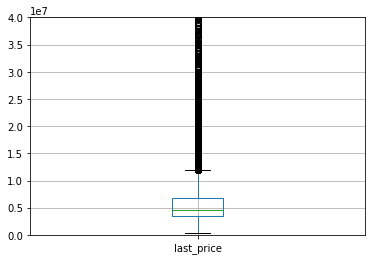

In [36]:
plt.ylim(0, 40000000)
df.boxplot('last_price')
plt.show()

Рассмотрим диаграмму размаха. Цены ниже межквартильного размаха расположены очень плотно. Вся недвижимость с ценой более 15 млн.руб. однозначно попадает в выбросы. Удалим наиболее "выделяющиеся" из общей массы, если их не очень много по сравнению с размером таблицы.

In [37]:
print('Удалено:\033[1m', 
      df.query('last_price>40000000')['last_price'].count(), 
      '\033[0mобъявлений с ценой более 40 млн. руб.')

df = df.query('last_price<=40000000')

print('Количество записей в базе данных:\033[1m', len(df), '\033[0m')

Удалено: 182 объявлений с ценой более 40 млн. руб.
Количество записей в базе данных: 23517 


##### Пропущенные названия населённых пунктов

В этом поле 49 пропущенных значений. Клиенты решили оставить в тайне местоположение своей недвижимости? Или произошел какой-то сбой при копировании данных. Посмотрим часть этих значений. Вдруг, в данные попали полностью пустые строки.

In [38]:
display(df[df['locality_name'].isna()].sample(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
21715,2,6047550.0,80.1,2018-07-30T00:00:00,2,NaN,9.0,30.5,2,False,False,False,29.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176.0,4
1097,3,8600000.0,81.7,2016-04-15T00:00:00,3,3.55,5.0,50.8,2,False,False,False,8.8,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0,4
20057,13,11500000.0,102.0,2015-10-14T00:00:00,2,NaN,5.0,70.0,2,False,False,False,15.1,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,325.0,4
19045,6,4650000.0,48.0,2016-01-25T00:00:00,2,3.12,5.0,26.2,1,False,False,False,8.0,0.0,NaN,21654.0,3312.0,1.0,549.0,1.0,858.0,254.0,2
22933,20,3176015.0,33.3,2015-04-22T00:00:00,1,NaN,23.0,15.4,22,False,False,False,9.0,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,427.0,0


Удивительно, что для некоторых безымянных объектов нашлись картографические данные. Заменим пропущенные значения на "не указан"

In [39]:
df['locality_name'] = df['locality_name'].fillna('не указан')

#### <font color='#473C8B'>Изменение типов данных</font>

Проверим, в каких столбцах, следует изменить тип данных

In [40]:
df.dtypes

total_images               int64
last_price               float64
total_area               float64
first_day_exposition      object
rooms                      int64
ceiling_height           float64
floors_total             float64
living_area              float64
floor                      int64
is_apartment                bool
studio                      bool
open_plan                   bool
kitchen_area             float64
balcony                  float64
locality_name             object
airports_nearest         float64
cityCenters_nearest      float64
parks_around3000         float64
parks_nearest            float64
ponds_around3000         float64
ponds_nearest            float64
days_exposition          float64
total_area_group        category
dtype: object

##### Дата публикации

Для дат в Pandas есть свой формат `datetime`. Судя по разным частям нашего датафрейма, которые мы выводили на экран выше, все данные столбца `first_day_exposition` записаны одинаково. И, кстати в данных указана только дата. Все значения времени равны нулю.

In [41]:
# преобразуем столбец в формат дат
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

##### Целочисленные значения 

Данные в столбцах, где указано количество чего-либо переведём из формата вещественных чисел `float64` в формат `int32`: 
- общее количество этажей, 
- количество балконов, 
- количество дней на сайте 

Обратим внимание, что все данные из поля количества дней `days_exposition` - целые числа, так как в поле дат не указано время.

Кроме того можно перевести из `int64` в формат `int32` поля, где не будет очень больших значений:
- количество фотографий, 
- количество комнат
- этаж квартиры,

 

- Цену также можно перевести в целые числа. 

Поля, где указано количество парков и водоёмов перевести в целочисленный формат не получится, так как там много пропущенных значений.

In [42]:
# преобразуем формат в целочисленный
df[['floors_total', 'balcony', 'days_exposition', 
    'total_images', 'rooms', 'floor']] = \
df[['floors_total', 'balcony', 'days_exposition', 
    'total_images', 'rooms', 'floor']].astype('int32')

df['last_price'] = df['last_price'].astype('int64')

##### Апартаменты

Для поля `is_apartment` поменяем тип `object` на логический тип `bool`.

In [43]:
df['is_apartment'] = df['is_apartment'].astype('bool')

##### Проверка 

Проверим, какие типы данных получились в исправленных столбцах

In [44]:
df[['first_day_exposition', 'last_price', 'floors_total', 
    'balcony', 'days_exposition', 'total_images', 
   'rooms', 'floor', 'is_apartment']].dtypes

first_day_exposition    datetime64[ns]
last_price                       int64
floors_total                     int32
balcony                          int32
days_exposition                  int32
total_images                     int32
rooms                            int32
floor                            int32
is_apartment                      bool
dtype: object

#### <font color='#473C8B'>Поиск дубликатов</font>


In [45]:
print('Количество явных дубликатов в датафрейме:\033[1m', df.duplicated().sum(), '\033[0m')

Количество явных дубликатов в датафрейме: 0 


##### Неявные дубликаты в названиях населённых пунктов 

Неявные дубликаты могут затаиться в <i>названии населённого пункта</i>.

In [46]:
print('Количество уникальных названий населённых пунктов:\033[1m', df['locality_name'].nunique(), '\033[0m')

Количество уникальных названий населённых пунктов: 365 


In [47]:
display(df.sort_values(by='locality_name')['locality_name'].unique())

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Количество уникальных значений - как дней в году! Попробуем разбить этот огромный список на два столбца, где сохраним отдельно название населённого пункта и тип (посёлок, деревня и т.п.). Нам очень повезло, что все названия начинаются исключительно с большой буквы.

In [48]:
# сохраним все уникальные значения в таблицу
locality_df = pd.DataFrame(df['locality_name'].unique(), columns=['locality_name'])

# добавим в таблицу два столбца из пустых строк, куда затем сохраним тип и название населённого пункта
locality_df['loc_type'] = ['']*len(locality_df)
locality_df['loc_name'] = ['']*len(locality_df)

# переберём все строки нашей таблицы
for row_num in locality_df.index:
    # сохраним название в переменную loc_str
    loc_str = locality_df.loc[row_num, 'locality_name']
    # заменим все ё на е
    loc_str = loc_str.replace('ё', 'е')
    
    # если в названии нет пробелов, то это скорее всего город
    if ' ' not in loc_str:
        locality_df.loc[row_num, 'loc_name'] = loc_str
        locality_df.loc[row_num, 'loc_type'] = ''
    
    # если название населённого пункта не указано, так и запишем
    elif loc_str == 'не указан':
        locality_df.loc[row_num, 'loc_name'] = 'не указан'
        locality_df.loc[row_num, 'loc_type'] = ''
    
    # для всех остальных случаев
    else:
        # разобьём строку на отдельные слова (по умолчанию по пробелу)
        loc_list = loc_str.split()
        # пройдём по словам получившегося списка
        for word in loc_list:
            # если слово начинается с заглавной буквы, то это - название
            if word.istitle():
                # если название населённого пункта пусто
                if locality_df.loc[row_num, 'loc_name']  == '':
                    # присвоим название населённому пункту
                    locality_df.loc[row_num, 'loc_name'] = word
                # если в названии уже что-то есть
                else:
                    # добавим продолжение названия через пробел
                    locality_df.loc[row_num, 'loc_name'] += ' ' + word
            # если слово начинается со строчной буквы, то это = тип
            else:
                # если тип населённого пункта пуст
                if locality_df.loc[row_num, 'loc_type']  == '':
                    # присвоим тип 
                    locality_df.loc[row_num, 'loc_type'] = word
                # если в типе населённого пункта уже есть слова
                else:
                    # добавим новое слово через пробел
                    locality_df.loc[row_num, 'loc_type'] += ' ' + word
                    
# Проверим какие типы населённых пунктов получились
locality_df['loc_type'].value_counts()

поселок                                      136
деревня                                      106
                                              44
поселок городского типа                       36
городской поселок                             14
село                                           9
поселок станции                                6
садовое товарищество                           4
поселок городского типа имени                  3
коттеджный поселок                             3
поселок при железнодорожной станции            2
садоводческое некоммерческое товарищество      1
поселок 69-й километр                          1
Name: loc_type, dtype: int64

In [49]:
# в случае "поселком городского типа имени" слово имени вернём названию
locality_df.loc[locality_df['loc_type']=='поселок городского типа имени', 'loc_name'] = \
    'имени ' + locality_df.loc[locality_df['loc_type']=='поселок городского типа имени', 'loc_name']
locality_df.loc[locality_df['loc_type']=='поселок городского типа имени', 'loc_type'] = \
    'поселок'

#  уберём слова "при железнодорожной"
locality_df.loc[locality_df['loc_type']=='поселок при железнодорожной станции', 'loc_type'] = \
    'поселок станции'

#  вернём "станцию" в название
locality_df.loc[locality_df['loc_type']=='поселок станции', 'loc_name'] = \
    'станция ' + locality_df.loc[locality_df['loc_type']=='поселок станции', 'loc_name']
locality_df.loc[locality_df['loc_type']=='поселок станции', 'loc_type'] = \
    'поселок'

#  переделаем "садоводческое некоммерческое товарищество"
locality_df.loc[locality_df['loc_type']=='садоводческое некоммерческое товарищество', 'loc_type'] = \
    'садовое товарищество'

# вернём "69-й километр" названию
locality_df.loc[locality_df['loc_type']=='поселок 69-й километр', 'loc_name'] += \
    ' 69-й километр'
locality_df.loc[locality_df['loc_type']=='поселок 69-й километр', 'loc_type'] = \
    'поселок'

# уберём все прилагательные у слова "посёлок"
locality_df.loc[locality_df['loc_type'].str.contains('поселок'), 'loc_type'] = 'поселок'

# проверим новые типы и нет ли одинаковых названий с разными типами
display(locality_df['loc_type'].value_counts())

поселок                 201
деревня                 106
                         44
село                      9
садовое товарищество      5
Name: loc_type, dtype: int64

In [50]:
# найдем разные типы населённых пунктов с одинаковыми названиями
for find_name in locality_df['loc_name'].unique():
    if locality_df[locality_df['loc_name']==find_name]['loc_type'].nunique()>1:
        print(find_name, locality_df[locality_df['loc_name']==find_name]['loc_type'].unique())

Мурино ['поселок' '']
Кудрово ['деревня' '']
Федоровское ['деревня' 'поселок']
Никольское ['' 'село']
Павлово ['село' 'поселок']
Рахья ['поселок' 'садовое товарищество']
Зимитицы ['поселок' 'деревня']
Калитино ['деревня' 'поселок']
Приладожский ['поселок' 'садовое товарищество']
Щеглово ['поселок' 'деревня']
Рабитицы ['деревня' 'поселок']
Гарболово ['деревня' 'поселок']
Любань ['' 'поселок']


К сожалению, эту часть работы придется осуществить в ручную с помощью Яндекс Карт. 
- Мурино до 2019 года был посёлком, а потом стал городом. Сделаем всё городом, чтобы жителям было не обидно.
- Кудрово - город, такой деревни не нашлось.
- Фёдоровское и Любань - городские поселения. Так как мы исправляли для других городские поселения на посёлок, то и здесь заменим на посёлок.
- Гарболово - деревня.
- Никольское - а тут неожиданность: в Ленинградской области есть и город, и село Никольское. Не будем ничего менять.
- Павлово - село и посёлок тоже разные в разных районах области.
- Рахья, Зимитицы,  Калитино, Приладожский, Щеглово, Рабитицы - для каждого из этих случаев географически существуют разные населённые пункты с одинаковым названием, которые находятся рядом. Для нашей задачи (влияние расстояний на цену например) это неважно. Поэтому оставим везде только одно из названий, более крупное в географическом понятии.

In [51]:
# заменим
locality_df.loc[locality_df['loc_name'].isin(['Мурино','Кудрово']), \
                'loc_type'] = ''

locality_df.loc[locality_df['loc_name'].isin(['Федоровское', 'Рахья', 'Зимитицы', \
                                            'Калитино', 'Приладожский', 'Щеглово', \
                                            'Рабитицы', 'Любань']), \
                'loc_type'] = 'поселок'

locality_df.loc[locality_df['loc_name']=='Гарболово', 'loc_type'] = 'деревня'

# проверим кто остался
for find_name in locality_df['loc_name'].unique():
    if locality_df[locality_df['loc_name']==find_name]['loc_type'].nunique()>1:
        print(find_name, locality_df[locality_df['loc_name']==find_name]['loc_type'].unique())      

Никольское ['' 'село']
Павлово ['село' 'поселок']


В ходе работы с названиями населённых пунктов, было замечено, что и в базе данных, и в действительности в Ленинградской области, существуют разные населённые пункты с одинаковым названием. Например:
- город Никольское и посёлок Никольское;
- посёлок Павлово и село Павлово
 
Если названия и типы населенных пунктов записать в наш датафрейм по-отдельности, то возникнет путаница. Поэтому объединим обратно названия и типы населенных пунктов.

In [52]:
# если название типа населенного пункта не пустое, то добавим в конец пробел
locality_df.loc[locality_df['loc_type']!='', 'loc_type'] += ' '

# соединим столбцы
locality_df['locality'] = locality_df['loc_type'] + locality_df['loc_name']

display(locality_df.sort_values(by='locality')['locality'].unique())

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Мурино', 'Никольское', 'Новая Ладога',
       'Отрадное', 'Павловск', 'Петергоф', 'Пикалево', 'Подпорожье',
       'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург', 'Светогорск',
       'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор', 'Сясьстрой',
       'Тихвин', 'Тосно', 'Шлиссельбург', 'деревня Агалатово',
       'деревня Аро', 'деревня Батово', 'деревня Бегуницы',
       'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выскатка', 'деревн

Я внимательно прочитала весь получившийся список. Убедилась, что Кингисепп и Кингисеппский рядом, но не одно и то же. Коммунар и Коммунары разные. Передайте привет Левенштейну! В следующий раз буду использовать библиотеку его имени, а пока не хватило времени. 

Теперь добавим новые названия в наш датафрейм.

In [53]:
# оставим в таблице только изначальный и итоговый столбцы
locality_df=locality_df[['locality_name', 'locality']]

# соединим наш датафрейм с таблицей названий
df = df.merge(locality_df, on='locality_name', how='left')

# присвоим старому столбцу новые названия и удалим лишний столбец
df['locality_name'] = df['locality']
df = df.drop('locality', axis=1)

# проверим, что получилось
print('Количество уникальных значений в названиях населённых пунктов:\033[1m', df['locality_name'].nunique(), '\033[0m')
df.sample(5)

Количество уникальных значений в названиях населённых пунктов: 309 


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
23064,9,4950000,55.0,2017-11-20,2,2.53,4,34.0,2,False,False,False,9.3,1,Пушкин,20040.0,30561.0,0.0,NaN,0.0,NaN,36,2
7038,3,7900000,134.0,2015-07-09,4,NaN,3,78.0,2,False,False,False,19.9,0,Кронштадт,67850.0,49575.0,1.0,627.0,3.0,116.0,1183,4
7186,5,6110000,62.5,2017-07-13,2,NaN,13,32.0,3,False,False,False,10.9,2,Санкт-Петербург,37434.0,8460.0,1.0,441.0,2.0,427.0,60,3
3045,20,2000000,80.0,2018-01-03,3,NaN,1,48.5,1,False,False,False,10.0,0,Волосово,NaN,NaN,NaN,NaN,NaN,NaN,44,4
7550,18,4730000,58.4,2018-01-22,3,2.55,9,37.4,8,False,False,False,7.0,0,Санкт-Петербург,31657.0,12662.0,0.0,NaN,0.0,NaN,25,3


##### Поиск неявных дубликатов по разным срезам данных

Попробуем найти в нашем датафрейме такие строки, которые совпадают не полностью, но могут относится к одному и тому же объекту недвижимости. В том случае, если клиент несколько раз опубликовал объявления, указав разные данные. Попробуем сделать выборки по разным столбцам и поискать дубликаты.

In [54]:
# создадим список для разных имён столбцов. Можно его по-разному менять и выводить дубликаты
# Например, для такой группы столбцов
dupli_list = ['total_images', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'floor',
       'balcony', 'locality_name']

# найдём дубликаты и выведем первую и последнюю строку среди дубликатов
display(df[df[dupli_list].duplicated()])
display(df[df[dupli_list].duplicated(keep='last')])

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
14765,6,7433186,60.4,2018-07-24,2,3.0,4,37.20,2,False,False,False,10.94,1,Санкт-Петербург,44870.0,20802.0,0.0,NaN,1.0,792.0,0,3
23335,3,22529250,139.5,2018-07-04,4,3.3,16,82.55,9,False,False,False,13.84,0,Санкт-Петербург,37434.0,8460.0,1.0,441.0,2.0,427.0,266,4


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
11029,6,6812033,60.4,2018-07-24,2,3.0,4,37.20,2,False,False,False,10.44,1,Санкт-Петербург,44870.0,20802.0,0.0,NaN,1.0,792.0,219,3
12277,3,18206548,139.5,2018-07-04,4,3.3,16,82.55,9,False,False,False,13.84,0,Санкт-Петербург,37434.0,8460.0,1.0,441.0,2.0,427.0,0,4


Очень похожие записи, хотя и совпадающие не по всем полям. Если сравнить попарно, то отличаются только: 
- площадь кухни в одном случае (она могла быть не указана в одной из строк, а мы её высчитали позже);
- цена (причем не кратная 10);
- количество дней на сайте одно из значений в каждой паре - нулевое)

Похоже, что кто-то, начиная публиковать объявление его сохранил, что-то поменял или добавил. Затем опубликовал окончательный вариант. Неопубликованное объявление осталось, но количество дней на сайте не рассчитывалось. 

Возможен и такой вариант, что это разные квартиры на одном этаже. Владелец или риэлтор выкладывают объявления (или и тот, и другой). Поэтому цена отличается. 

In [55]:
# те же столбцы, но без совпадения количества фотографий
dupli_list = ['total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'floor',
       'balcony', 'locality_name']

# первое значение и последнее среди дубликатов
display(df[df[dupli_list].duplicated()].sort_values(by='total_area'))
display(df[df[dupli_list].duplicated(keep='last' )].sort_values(by='total_area'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
3951,0,2600000,31.0,2017-12-08,1,NaN,5,18.00,1,False,False,False,6.50,0,Санкт-Петербург,44813.0,14392.0,2.0,262.0,0.0,NaN,15,0
16161,3,4350000,34.0,2017-10-13,1,2.60,9,17.40,7,False,False,False,7.80,1,Санкт-Петербург,15758.0,11479.0,1.0,580.0,0.0,NaN,117,0
14765,6,7433186,60.4,2018-07-24,2,3.00,4,37.20,2,False,False,False,10.94,1,Санкт-Петербург,44870.0,20802.0,0.0,NaN,1.0,792.0,0,3
18435,1,5400043,68.8,2018-11-16,2,2.75,22,35.55,16,False,False,False,13.67,0,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,20,3
23335,3,22529250,139.5,2018-07-04,4,3.30,16,82.55,9,False,False,False,13.84,0,Санкт-Петербург,37434.0,8460.0,1.0,441.0,2.0,427.0,266,4
21932,1,23321944,165.2,2018-02-15,3,3.00,19,59.80,19,False,False,False,13.40,0,Санкт-Петербург,18995.0,4579.0,0.0,NaN,0.0,NaN,0,4


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
2791,13,2770000,31.0,2017-12-08,1,NaN,5,16.00,1,False,False,False,7.50,0,Санкт-Петербург,40705.0,10888.0,3.0,326.0,0.0,NaN,45,0
1647,6,3000000,34.0,2017-10-13,1,2.60,9,17.60,7,False,False,False,8.00,1,Санкт-Петербург,32711.0,11785.0,1.0,671.0,0.0,NaN,11,0
11029,6,6812033,60.4,2018-07-24,2,3.00,4,37.20,2,False,False,False,10.44,1,Санкт-Петербург,44870.0,20802.0,0.0,NaN,1.0,792.0,219,3
1787,6,5400000,68.8,2018-11-16,2,2.75,22,35.55,16,False,False,False,13.67,0,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,24,3
12277,3,18206548,139.5,2018-07-04,4,3.30,16,82.55,9,False,False,False,13.84,0,Санкт-Петербург,37434.0,8460.0,1.0,441.0,2.0,427.0,0,4
14469,7,20851478,165.2,2018-02-15,3,3.00,19,59.80,19,False,False,False,13.40,0,Санкт-Петербург,18971.0,4563.0,0.0,NaN,1.0,825.0,0,4


Вот еще похожие пары. Перебирать выборки по разным сочетаниям столбцов можно бесконечно.  
Тем более сложно судить, существовало ли одновременно в базе данных два объявления про одну и ту же квартиру. Или это похожие, но все-таки разные объекты недвижимости. 

Если в базе было несколько объявлений об одной и той же квартире, то как тогда определить, за какое время недвижимость была продана, была ли она продана вообще и тем более за какую из двух указанных цен? 

#### <font color='#473C8B'>Пропущенные значения в картографических данных</font>

Количество пропусков в разных полях, заполненных автоматически почти совпадают. Возможно, это связано с населенным пунктом. После "уборки" в названиях населённых пунктов, можем это проверить.

In [56]:
display(df[['airports_nearest', 'cityCenters_nearest', 'parks_around3000', 
    'parks_nearest', 'ponds_around3000', 'ponds_nearest']].isna().sum())

# Проверим, в каких строках не заполнены все картографические данные одновременно. Посчитаем эти строки
print('Нет никаких картографических данных:\033[1m', 
   len(df[(df['airports_nearest'].isna()) & (df['cityCenters_nearest'].isna()) & (df['parks_around3000'].isna()) & 
   (df['parks_nearest'].isna()) & (df['ponds_around3000'].isna()) & (df['ponds_nearest'].isna())]), '\033[0m строк')

print('Среди них Санкт-Петербург встречается:\033[1m', 
   len(df[(df['airports_nearest'].isna()) & (df['cityCenters_nearest'].isna()) & (df['parks_around3000'].isna()) & 
   (df['parks_nearest'].isna()) & (df['ponds_around3000'].isna()) & (df['ponds_nearest'].isna()) & 
   (df['locality_name'] == 'Санкт-Петербург')]), '\033[0m раз,')

print('а населённый пункт не указан:          \033[1m', 
   len(df[(df['airports_nearest'].isna()) & (df['cityCenters_nearest'].isna()) & (df['parks_around3000'].isna()) & 
   (df['parks_nearest'].isna()) & (df['ponds_around3000'].isna()) & (df['ponds_nearest'].isna()) & 
   (df['locality_name'] == 'не указан')]), '\033[0m раз')

airports_nearest        5536
cityCenters_nearest     5516
parks_around3000        5515
parks_nearest          15577
ponds_around3000        5515
ponds_nearest          14555
dtype: int64

Нет никаких картографических данных: 5515  строк
Среди них Санкт-Петербург встречается: 58  раз,
а населённый пункт не указан:           8  раз


Судя по этим цифрам, картографические данные были рассчитаны в основном для Санкт-Петербурга. 

Попытаемся заполнить пропущенные значения медианами по сгруппированным данным в зависимости от населённого пункта. Тем более, что для небольших посёлков и городов такие величины, как расстояние от аэропорта или от центра города не должны сильно отличаться.

In [57]:
# создадим сводную таблицу, куда внесём медианы картографических данных
# в зависимости от населённого пункта
map_df = df.pivot_table(
    index='locality_name', 
    values=['airports_nearest', 'cityCenters_nearest', 
            'parks_around3000', 'parks_nearest', 
            'ponds_around3000', 'ponds_nearest'],
    aggfunc='median')

# отсортируем таблицу по дальности от центра
map_df = map_df.sort_values(by='cityCenters_nearest')

display(map_df.head())

,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
locality_name,,,,,,
не указан,22041.0,8943.0,0.0,472.0,1.0,374.0
Санкт-Петербург,26798.0,12295.5,0.0,463.0,1.0,506.0
поселок Парголово,53426.0,19311.0,0.0,733.0,0.0,593.0
Мурино,51553.0,21888.0,0.0,NaN,2.0,133.0
поселок Стрельна,28317.0,23506.0,0.0,700.0,1.0,859.0


Интересно, что в верхней строке, куда попали самые близлижащие к центру районы, оказались данные, в которых населённых пункт неизвестен. И медианные значения почти совпадают со значением для Санкт-Петербурга. Значит, большинство тех, кто не указал, где находится его недвижимость, живут в Санкт-Петербурге. 

Если мы будем заполнять пропуски медианами, все объявления, где город не указан, всё равно "попадут" в Санкт-Петербург. Найдем минимальное расстояние от центра, которое уже не будет являться Санкт-Петербургом. Также учтём, что Пулково находится в черте города. А других аэропортов поблизости нет. 

In [58]:
print('Минимальное расстояние от центра для других населённых пунктов:  \033[1m', 
      df[(df['locality_name']!='Санкт-Петербург') & 
         (df['locality_name']!='не указан')]['cityCenters_nearest'].min(), '\033[0m')
print('Минимальное расстояние от аэропорта для других населённых пунктов:\033[1m', 
      df[(df['locality_name']!='Санкт-Петербург') & 
         (df['locality_name']!='не указан')]['airports_nearest'].min(),   '\033[0m')

Минимальное расстояние от центра для других населённых пунктов:   17012.0 
Минимальное расстояние от аэропорта для других населённых пунктов: 9294.0 


Для тех населённых пунктов, где не указано название заменим "не указан" на "Санкт-Петербург" в следующих случаях:
- если пропущены значения расстояния от центра города и от аэропорта;
- если расстояние от центра указано и оно меньше 17 км;
- если расстояние до аэропорта указано и оно меньше 9 км.

In [59]:
df.loc[(df['cityCenters_nearest'].isna()) & 
       (df['airports_nearest'].isna()) & 
       (df['locality_name']=='не указан'), 'locality_name'] = 'Санкт-Петербург'
df.loc[(~df['cityCenters_nearest'].isna()) & 
       (df['cityCenters_nearest']<17000) & 
       (df['locality_name']=='не указан'), 'locality_name'] = 'Санкт-Петербург'
df.loc[(~df['airports_nearest'].isna()) & 
       (df['airports_nearest']<9000) & 
       (df['locality_name']=='не указан'), 'locality_name'] = 'Санкт-Петербург'

# снова создадим сводную таблицу
map_df = df.pivot_table(
    index='locality_name', 
    values=['airports_nearest', 'cityCenters_nearest', 
            'parks_around3000', 'parks_nearest', 
            'ponds_around3000', 'ponds_nearest'],
    aggfunc='median')

# отсортируем таблицу по дальности от центра
map_df = map_df.sort_values(by='cityCenters_nearest')

# посмотрим, что получилось
display(map_df.head())
print('Количество пропущенных значений в сводной таблице')
map_df.isna().sum()

,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
locality_name,,,,,,
Санкт-Петербург,26776.0,12290.0,0.0,463.0,1.0,506.0
не указан,22041.0,17369.0,0.0,NaN,1.0,374.0
поселок Парголово,53426.0,19311.0,0.0,733.0,0.0,593.0
Мурино,51553.0,21888.0,0.0,NaN,2.0,133.0
поселок Стрельна,28317.0,23506.0,0.0,700.0,1.0,859.0


Количество пропущенных значений в сводной таблице


airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest          16
ponds_around3000        0
ponds_nearest           8
dtype: int64

Перед тем, как заменять пропущенные значения картографических данных во всём датафрейме, сначала исправим сводную таблицу следующим образом:

1) проверим, нет ли таких случаев, когда количество парков или водоёмов больше нуля, а расстояние до них равно нулю

2) если в сводной таблице количество парков (или водоёмов) равно нулю, а расстояние до парка (или водоёма) больше нуля, заменим количество на 1;

3) все пропущенные расстояния заменим на 3 000 (так как считаются парки и водоёмы на расстоянии 3км, а если парка или водоёма нет, то замена нулями приведёт к искажению данных);



In [60]:
# проверим на сответствие в обратном случае - когда парки или водоемы есть, а расстояние до них нулевое
# map_df.query('(parks_around3000 > 0 & parks_nearest == 0) | \
#               (ponds_around3000 > 0 & ponds_nearest == 0)')['cityCenters_nearest'].count()
# результат нулевой, поэтому закомментировано

# пройдём с проверкой по всем строкам сводной таблицы по индексам
for map_ind in map_df.index:
    # если парков нет, а расстояние до них больше нуля
    if map_df.loc[map_ind, 'parks_around3000'] == 0 and map_df.loc[map_ind, 'parks_nearest'] > 0:
        map_df.loc[map_ind, 'parks_around3000'] = 1
    #  если водоемов нет, а расстояние до них больше нуля
    if map_df.loc[map_ind, 'ponds_around3000'] == 0 and map_df.loc[map_ind, 'ponds_nearest'] > 0:
        map_df.loc[map_ind, 'ponds_around3000'] = 1

# заменим пропущенные значения на 3 км
map_df = map_df.fillna(3000)
        
print('Количество строк в сводной таблице:\033[1m', len(map_df), '\033[0m')

map_df.sample(5)

Количество строк в сводной таблице: 28 


,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
locality_name,,,,,,
Санкт-Петербург,26776.0,12290.0,1.0,463.0,1.0,506.0
поселок Шушары,17427.0,24212.0,0.0,3000.0,1.0,584.5
Сестрорецк,56692.0,34821.0,1.0,367.0,1.0,372.0
поселок Петро-Славянка,20605.0,27165.0,0.0,3000.0,2.0,663.0
поселок Молодежное,84665.0,65764.0,0.0,3000.0,0.0,3000.0


Обратим внимание, что в нашу сводную таблицу попало всего 28 населённых пунктов из 309. Те строки датафрейма, где сразу все картографические данные не были указаны, в сводную таблицу не вошли. Заменим пропуски в тех данных, где это возможно.

In [61]:
# будем искать пропущенные значения по названиям столбцов в сводной таблице
for col_name in map_df.columns:
    # так как в сводную таблицу вошли не все населенные пункты, то 
    # перебор осуществляем только по тем значениям, которые есть
    for loc_name in map_df.index:
        # проверяем если в этом населенном пункте и этой колонке значение пропущено 
        # заменяем его на значение из сводной таблицы с помощью метода mask
        df [col_name] = df[col_name].mask((df['locality_name']==loc_name) & (df[col_name].isna()), 
                                            map_df.loc[loc_name, col_name])

# проверим, сколько осталось пропущенных значений
# df[['airports_nearest', 'cityCenters_nearest', 'parks_around3000', 
#    'parks_nearest', 'ponds_around3000', 'ponds_nearest']].isna().sum()

In [62]:
df[['airports_nearest', 'cityCenters_nearest', 'parks_around3000', 
   'parks_nearest', 'ponds_around3000', 'ponds_nearest']].isna().sum()

airports_nearest       4829
cityCenters_nearest    4829
parks_around3000       4829
parks_nearest          4829
ponds_around3000       4829
ponds_nearest          4829
dtype: int64

In [63]:
print('Не заполнены картографические данные в \033[1m', 
      df[df['ponds_nearest'].isna()]['locality_name'].count(), '\033[0m записях для \033[1m', 
      df[df['ponds_nearest'].isna()]['locality_name'].nunique(), '\033[0m населённых пунктов.')

Не заполнены картографические данные в  4829  записях для  281  населённых пунктов.


#### <font color='#473C8B'>Поиск несоответствий в картографических данных</font>

В процессе замены пропущенных значений было замечено, что зачастую указано количество парков или водоёмов равное нулю, а расстояние до них ненулевое. Проверим такие варианты во всей таблице.

In [64]:
print('Расстояние равно нулю при наличии парка или водоёма поблизости:\033[1m',
      df.query('(parks_around3000 > 0 & parks_nearest == 0) | \
               (ponds_around3000 > 0 & ponds_nearest == 0)')['cityCenters_nearest'].count(), '\033[0m')
print('Расстояние указано и оно меньше 3км, а парка или водоёма нет:\033[1m',
      df.query('(parks_around3000 == 0 & (3000 > parks_nearest > 0)) | \
              (ponds_around3000 == 0 & (3000 > ponds_nearest > 0))')['cityCenters_nearest'].count(), '\033[0m')

Расстояние равно нулю при наличии парка или водоёма поблизости: 0 
Расстояние указано и оно меньше 3км, а парка или водоёма нет: 13027 


In [65]:
# заменим в некорректных случаях количество парков или водоёмов на 1, 
# как мы делали это для сводной таблицы - перебором по строкам датафрейма
for df_ind in df.index:
    # если парков нет, а расстояние до них больше нуля и меньше 3 км
    if df.loc[df_ind, 'parks_around3000'] == 0 and 3000 > df.loc[df_ind, 'parks_nearest'] > 0:
        df.loc[df_ind, 'parks_around3000'] = 1
    #  если водоемов нет, а расстояние до них больше нуля и меньше 3 км
    if df.loc[df_ind, 'ponds_around3000'] == 0 and 3000 > df.loc[df_ind, 'ponds_nearest'] > 0:
        df.loc[df_ind, 'ponds_around3000'] = 1

#### <font color='#473C8B'>Итоги предобработки данных</font>

<div style="text-align: justify; padding: 10px 10px 10px 30px">
    
<b>1)</b> В ходе изучения и предобработки данных были заполнены пропущенные значения:
- жилая площадь и площадь кухни;
- количество балконов и этажей в доме;
- количество дней, когда объявление было на сайте;
- поле апартаментов;
- название населённого пункта;
- картографических данные - в тех случаях, когда это оказалось возможным.
    
<b>2)</b> Оставлены пустые значения высоты потолков (неизвестно как их рассчитать).

<b>3)</b> Пропуски в количестве дней на сайте не были удалены, так как неизвестна однозначная причина их появления - объявление было опубликовано, но значения не были рассчитаны или объявление вообще не было опубликовано на сайте.

<b>4)</b> Все квартиры были разбиты на группы в зависимости от общей площади. Категории сохранены в столбце `total_area_group`.

<b>5)</b> Найдены и заменены аномальные значения в столбцах:
- количество комнат          - не соответствовало размерам квартиры;
- жилая площадь              - исправлена в 64 строках;
- количество этажей          - 3 значения для слишком высоких домов;
- высота потолков            - 3 очень "низких" и 4 очень "высоких" квартиры;
- высота потолков            - значения от 20 до 40 метров уменьшены в 10 раз;
- количество балконов        - подозрительно большие значения исправлены на 1;
- цена                       - 1 слишком низкая цена увеличина в 1000 раз.

<b>6)</b> Удалено 182 строки с ценами выше 40 млн.руб., которые определяются как выбросы.
    
<b>6)</b> Заменены несоответствия в данных о парках и водоёмах и расстояниях до них:
- если расстояние было указано, а количество парков или водоёмов - нет, то количество исправлено на 1;
- расстояния равные нулю заменены на 3000.
    
<b>7)</b> Был изменён тип данных:
- для даты размещения объявления на сайте - в формат `datetime64`;
- все столбцы с указанием количества чего-либо переведены в формат `int32` (кроме картографических данных, где содержится много пропущенных значений);
- столбец апартаменты из `object` преобразован в логический тип данных `bool`.

<b>8)</b> Преобразованы названия населённых пунктов. Из <b>365</b> уникальных значений получилось <b>309</b>. Новые названия записаны на прежнее место.

<b>9)</b> Было проверено, что в данных нет явных дубликатов. И предприняты почти безуспешные попытки найти неявные дубликаты.</div>

#### <font color='#473C8B'>Выводы (предобработка данных)</font>

<div style="text-align: justify; padding: 10px 10px 10px 30px">
    
- В таблице существуют очень похожие строки. 
    
    Например: объявления были опубликованы в одном и том же населенном пункте в один и тот же день, полностью совпадают почти все данные - общая площадь, количество комнат, этажность. В некоторых из этих объявлений совпадает или почти совпадает количество дней на сайте. Но разнятся данные о количестве фотографий и цене. До конца не ясно - относятся ли эти записи в таблице к одному и тому же объекту недвижимости. Возможно, что это похожие квартиры в новостройках, а объявление опубликовали риэлторы. Либо сохранилась какая-то копия объявления на сайте. И еще один вариант - клиент специально опубликовал несколько объявлений, чтобы было больше шансов найти покупателя. 
    
    Ещё один пример: две загадочные квартиры из разных деревень. Абсолютно все поля совпадают (в том числе дата публикации, количество фотографий, цена), кроме площади кухни и на один день отличаются количество дней на сайте. Может быть это мошенник продал свою квартиру дважды. А в названии населённого пункта указал две соседние деревни. Как бы ни было - оба объявления были опубликованы на сайте. 
    
    
- Существуют цены на квартиры, не кратные десяти. Причина таких цен не вполне ясна. Это могут быть цены от банка (например квартира продается за долги по ипотеке), или цена, которая каким-либо способом автоматически рассчитана. А может это ошибки в данных (например, в таблицу попали какие-то промежуточные суммы).
    
    
- Есть очень высокие и очень низкие значения общей площади недвижимости - от пентхаузов до комнат в коммунальной квартире.
    
    
- Все жилые помещения, в которых указано 0 комнат являются либо студиями, либо квартирами со свободной планировкой. 
    
    
- Большинство тех, кто не указал название населённого пункта живут в Санкт-Петербурге. 
    
    
- Если в количестве дней на сайте указан 0, значит в исходных данных это значение было пропущено.
    
    
- При анализе влияния количества балконов, стоит учитывать только их наличие. Есть вероятность, что часть клиентов вместо количества указала, например, площадь балкона. А среди нулевых значений - большая часть содержала пропуски в исходных данных.
    
    
- Замечено, что чем больше общая площадь квартиры, тем меньшую часть от этой площади занимает кухня.
</div>
<hr>

### Посчитайте и добавьте в таблицу новые столбцы

#### <font color='#473C8B'>Добавление новых полей</font>

#####  Цена одного квадратного метра жилья (в руб. за кв.м)

In [66]:
# разделим цену на общую площадь и округлим до целого
df['price_per_meter'] = round(df['last_price']/df['total_area'], 0)

#####  День недели, месяц и год публикации объявления

In [67]:
# воспользуемся методами Pandas для работы с датами
df['exposition_weekday'] = df['first_day_exposition'].dt.weekday
df['exposition_month'] = df['first_day_exposition'].dt.month
df['exposition_year'] = df['first_day_exposition'].dt.year

#####  Тип этажа квартиры

In [68]:
# создадим функцию для категоризации по типу этажа
def floor_type_counter (floors_list): 
    ''' принимает параметр 
    floors_list - значения из двух столбцов таблицы
    в первом столбце должен быть этаж,
    во втором - количество этажей
    '''
    if floors_list[0] == 1:
        return 'первый'
    if floors_list[0] == floors_list[1]:
        return 'последний'
    return 'другой'

# применим функцию к двум столбцам одновременно, указав axis=1, чтобы значения передавались из одной строки
df['floor_type']=df[['floor', 'floors_total']].apply(floor_type_counter, axis=1)

#####  Расстояния

In [69]:
# расстояние до центра города в километрах
df['center_distance'] = round(df['cityCenters_nearest']/1000, 0)
# расстояние до аэропорта в километрах
df['airport_distance'] = round(df['airports_nearest']/1000, 0)

#####  Цена

Добавим также столбец с указанием цены в миллионах для удобства при визуализации

In [70]:
# цена в миллионах, округленная до десятков тысяч
df['price_mln'] = round(df['last_price']/1000000, 2)

#####  Проверка

In [71]:
# проверим, какие получились столбцы 
display(df.sample(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,price_per_meter,exposition_weekday,exposition_month,exposition_year,floor_type,center_distance,airport_distance,price_mln
17923,11,3600000,23.8,2018-06-22,1,NaN,25,16.8,13,False,False,False,3.0,2,Санкт-Петербург,...,11870.0,1.0,533.0,1.0,927.0,129,0,151261.0,4,6,2018,другой,12.0,28.0,3.60
2460,9,4250000,44.0,2016-06-23,2,NaN,5,28.0,5,False,False,False,6.0,0,Санкт-Петербург,...,10319.0,1.0,2348.0,1.0,412.0,104,1,96591.0,3,6,2016,последний,10.0,14.0,4.25
19994,5,3500000,34.6,2015-12-18,1,2.6,25,15.7,11,False,False,False,9.6,0,Санкт-Петербург,...,12012.0,1.0,463.0,1.0,506.0,545,0,101156.0,4,12,2015,другой,12.0,43.0,3.50
22778,15,3200000,32.6,2017-01-21,1,NaN,12,17.5,10,False,False,False,7.0,2,Санкт-Петербург,...,14435.0,2.0,90.0,1.0,284.0,140,0,98160.0,5,1,2017,другой,14.0,50.0,3.20
1093,9,6100000,47.0,2017-12-18,1,2.8,20,16.0,5,False,False,False,13.0,2,Санкт-Петербург,...,15486.0,1.0,463.0,1.0,571.0,60,2,129787.0,0,12,2017,другой,15.0,52.0,6.10


#### <font color='#473C8B'>Итоги</font>

<div style="text-align: justify; padding: 10px 10px 10px 30px">    
В таблицу были добавлены новые столбцы:
    
- `total_area_group`- категории общей площади недвижимости (от 0 до 4, чем больше цифра, тем больше площадь);
    
- `price_per_meter`- цена за один квадратный метр площади;
    
- `exposition_weekday` - день недели, когда было опубликовано объявление;
    
- `exposition_month` - номер месяца, когда было опубликовано объявление;
    
- `exposition_year` - год, когда было опубликовано объявление;
    
- `floor_type` - тип этажа квартиры (первый, последний или другой); 
    
- `center_distance` - расстояние до центра города в километрах;
    
- `airport_distance` - расстояние до аэропорта в километрах;
    
- `price_mln` - округленная цена в миллионах рублей.

### Проведите исследовательский анализ данных

#### <font color='#473C8B'>Изучение данных</font>

##### Изучение параметров площади

Проанализируем сразу общую, жилую и площадь кухни

,total_area,living_area,kitchen_area
min,12.0,0.0,1.3
mean,58.9,33.7,10.3
median,52.0,30.0,9.0
max,470.3,279.6,100.7


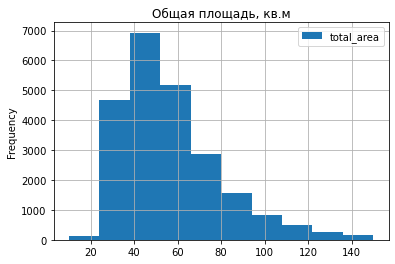

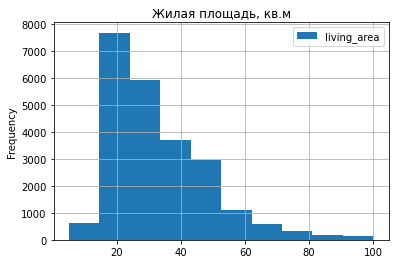

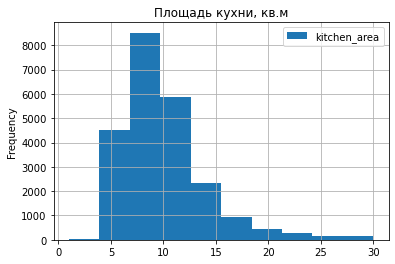

In [72]:
# Рассчитаем основные метрики, значения округлим для удобства восприятия
display(round(df[['total_area', 'living_area', 'kitchen_area']].agg(['min', 'mean', 'median', 'max']), 1))

# построим гистограмму для общей площади квартир
df.plot(y='total_area', title='Общая площадь, кв.м', grid=True, figsize=(6,4),
         kind='hist', bins=10, range=(10, 150))

# построим гистограмму для жилой площади квартир
df.plot(y='living_area', title='Жилая площадь, кв.м', grid=True, figsize=(6,4),
         kind='hist', bins=10, range=(5, 100))

# построим гистограмму для площади кухни
df.plot(y='kitchen_area', title='Площадь кухни, кв.м', grid=True, figsize=(6,4),
         kind='hist', bins=10, range=(1, 30))
plt.show()

Учитывая, что в нашей базе данных более 23 тысяч строк, можно сказать, что половина всех объектов недвижимости на рынке - обычные квартиры площадью около 40-70кв.м. Четверть от общего количества - жильё площадью до 40кв.м. Чем больше площадь, тем меньшее количество таких квартир. Доля огромных площадей на рынке недвижимости совсем небольшая. Размеры жилой части почти повторяют распределение общей площади.

В процессе предобработки данных общая площадь квартир была разбита на категории. Создана сводная таблица `df_area_pivot`, где были собраны медианы площадей по категориям общей площади. Построим по этой таблице столбчатую диаграмму.

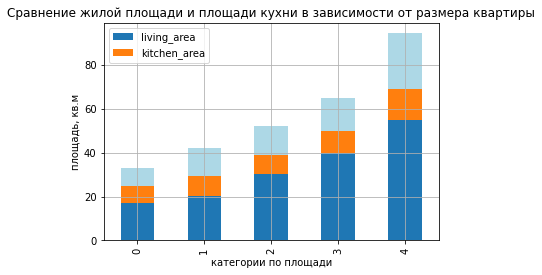

In [73]:
# построим столбчатую диаграмму сначала для общей площади квартир по категориям
ax_df = df_area_pivot['total_area'].plot(kind='bar', stacked=True, color='lightblue')

# затем добавим сверху столбчатую диаграмму для жилой площади и кухни,
# параметр stacked=True "поставит" столбики друг на друга
df_area_pivot[['living_area', 'kitchen_area']].plot(
        kind='bar', stacked=True, ax=ax_df, grid=True, 
        xlabel='категории по площади', ylabel='площадь, кв.м', 
        title='Сравнение жилой площади и площади кухни в зависимости от размера квартиры')
plt.show()

Доля жилой площади почти всегда занимает чуть больше половины всей площади квартиры. Тогда как чем больше жильё, тем меньшую часть занимает кухня. Разница в пропорциях столбцов небольшая. Скорее всего корелляция общей площади с показателями для нашего исследования будет такой же, как и корелляция жилой площади. 

##### Изучение цен на недвижимость

Характерные значения цены, млн.руб.:


,price_mln
count,23517.000
mean,5.913
std,4.615
min,0.430
25%,3.400
50%,4.600
75%,6.700
max,40.000


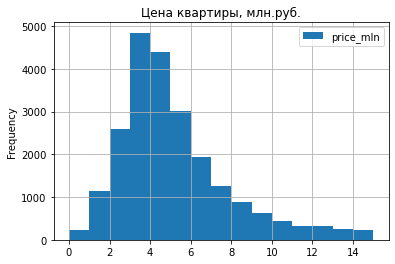

In [74]:
print('Характерные значения цены,\033[1m млн.руб.\033[0m:')
display(round(df[['price_mln']].describe(), 3))

# построим гистограмму для цены в миллионах
df.plot(y='price_mln', title='Цена квартиры, млн.руб.', grid=True, figsize=(6,4),
         kind='hist', bins=15, range=(0, 15))
plt.show()

##### Количество комнат

,rooms
min,0.0
median,2.0
max,19.0


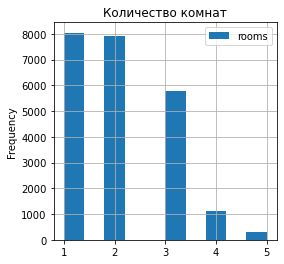

In [75]:
display(df[["rooms"]].agg(["min","median", "max"]))

# построим гистограмму количества комнат
df.plot(y='rooms', title='Количество комнат', grid=True, figsize=(4,4),
         kind='hist', bins=10, range=(1, 5));

Среди всех данных только 197 записей имели количество комнат равное нулю. Судя по гистограмме, приблизительно по 8 тысяч клиентов указали 1 или 2 комнаты, почти 6 тысяч - 3. Среднестатистическая квартира на рынке недвижимости имеет только 2 комнаты.

##### Изучение данных о высоте потолков

,ceiling_height
min,2.00
median,2.65
max,8.00


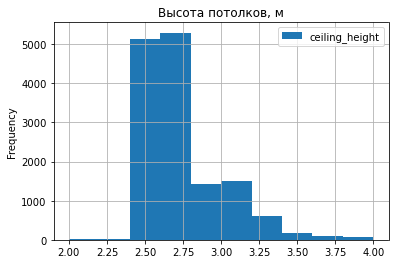

In [76]:
display(df[["ceiling_height"]].agg(["min","median", "max"]))
      
# построим гистограмму
df.plot(y='ceiling_height', title='Высота потолков, м', grid=True, figsize=(6,4),
         kind='hist', bins=10, range=(2, 4));

Несмотря на то, что существуют уникальные квартиры с высокими потолками в старом жилом фонде Санкт-Петербурга, половина всех квартир имеют вполне обычную высоту потолков от 2.5 до 2.8м. Аномально высокие значения в этом поле есть, но их не очень много.

##### Изучение параметров, связанных с этажами

У нас есть 3 поля значений - этаж, количество этажей и тип. Проанализируем эти поля таблицы

,floor,floors_total
min,1.0,1.0
mean,6.0,11.0
median,4.0,9.0
max,33.0,36.0


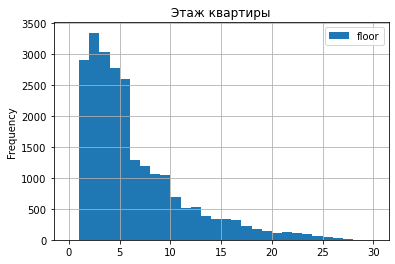

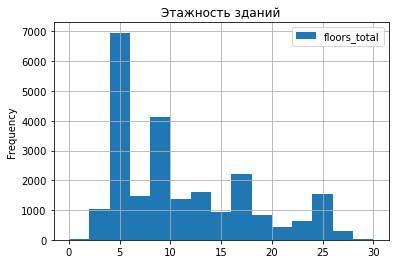

In [77]:
# Рассчитаем основные метрики, значения округлим для удобства восприятия
display(round(df[['floor', 'floors_total']].agg(['min', 'mean', 'median', 'max']), 0))

# построим гистограммы для этажей
df.plot(y='floor', title='Этаж квартиры', grid=True, figsize=(6,4),
         kind='hist', bins=30, range=(0, 30));
df.plot(y='floors_total', title='Этажность зданий', grid=True, figsize=(6,4),
         kind='hist', bins=15, range=(0, 30));

Распределение этажа квартиры малоинформативно. В базе данных представлены не только квартиры Санкт-Петербурга, но и области. Там количество этажей в зданиях, а следовательно и этаж, скорее всего окажутся гораздо ниже, чем по городу. 
Основная часть жилья из базы данных недвижимости находится не выше 6-го этажа. 

На гистограмме количества этажей получились интересные пики и ямы. Это можно объяснить тем, что в советское время строительство жилых домов было стандартизировано. Тогда основным жилым фондом во многих городах стали так называемые "хрущёвки" из 5 этажей, панельные 9-ти и 12-этажные дома (они попали во второй слева "пик"), а также 16-ти этажки. Позже часто строили дома в 24 и 26 этажей. 

В настоящее время, как выяснилось, чаще всего продают квартиры в домах с этажностью от 5 до 12.

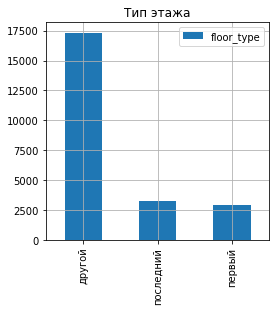

In [78]:
# гистограмма для типа этажей 
# построена как столбчатая диаграмма, построенная с помощью метода value_counts()
pd.DataFrame(df['floor_type'].value_counts()).\
    plot(y='floor_type', title='Тип этажа', grid=True, figsize=(4,4), kind='bar');

Очень интересно распределились значения. Приблизительно по 10% от всей недвижимости - это последний этаж (таких чуть больше) и первый (чуть меньше). Остальные 80% приходятся на квартиры "посередине" здания.

##### Изучение расстояний до центра города и аэропорта

Так как картографические данные были рассчитаны в основном для Санкт-Петербурга, попробуем проверить это с мощью гистрограммы.

расстояния до центра и аэропорта, км
расстояния до ближайшего парка и водоёма, м


,center_distance,airport_distance,parks_nearest,ponds_nearest
min,0.0,0.0,1.0,13.0
mean,14.5,29.6,637.6,515.1
median,13.0,27.0,463.0,506.0
max,66.0,85.0,3190.0,3000.0


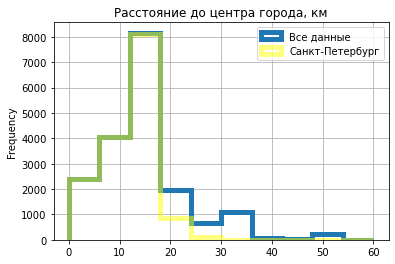

In [79]:
# Рассчитаем основные метрики, значения округлим для удобства восприятия
print('расстояния до центра и аэропорта, \033[1mкм\033[0m')
print('расстояния до ближайшего парка и водоёма, \033[1mм\033[0m')
display(round(df[['center_distance', 'airport_distance', 
                  'parks_nearest', 'ponds_nearest']].agg(['min', 'mean', 'median', 'max']), 1))

# построим гистограммы расстояний до центра города для всех значений,
# затем добавим поверх значения только для Санкт-Петербурга
ax_df = df.plot(y='center_distance', 
                kind='hist', bins=10, range=(0, 60),
                figsize=(6,4), histtype='step',
                linewidth=5, label='Все данные');

df.query('locality_name=="Санкт-Петербург"').plot(
                y='center_distance', ax=ax_df, grid=True,
                title='Расстояние до центра города, км',
                kind='hist', bins=10, range=(0, 60),
                figsize=(6,4), alpha=0.5, histtype='step', color='yellow',
                linewidth=5, label='Санкт-Петербург');

Одна треть всех объектов недвижимости из нашей базы данных находятся на окраинах Санкт-Петербурга на расстоянии от 13 до 17км от центра.  Приблизительно 10% - квартир в пределах 5км от центра города.

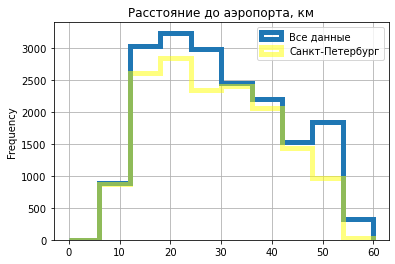

In [80]:
# построим гистограммы расстояний до аэропорта для всех значений,
# затем добавим поверх значения только для Санкт-Петербурга
ax_df = df.plot(y='airport_distance', 
                kind='hist', bins=10, range=(0, 60),
                figsize=(6,4), histtype='step',
                linewidth=5, label='Все данные');

df.query('locality_name=="Санкт-Петербург"').plot(
                y='airport_distance', ax=ax_df, grid=True,
                title='Расстояние до аэропорта, км',
                kind='hist', bins=10, range=(0, 60),
                figsize=(6,4), alpha=0.5, histtype='step', color='yellow',
                linewidth=5, label='Санкт-Петербург');

И здесь данные практически совпали. Пулково находится в черте города, других аэропортов в Ленинградской области нет. По информации из интернета - расстояние от Пулкова до центра Санкт-Петербурга 20 км, а максимальное расстояние до аэропорта в черте города - 60км, на этом же значении заканчивается жёлтый график. Основная масса квартир продаётся в районах города, которые находятся от 12 до 35км от аэропорта.

##### Изучение дальности от парков и водоёмов

Расстояния, м


,parks_nearest,ponds_nearest,parks_around3000,ponds_around3000
min,1.0,13.0,0.0,0.0
mean,637.6,515.1,1.1,1.3
median,463.0,506.0,1.0,1.0
max,3190.0,3000.0,3.0,3.0


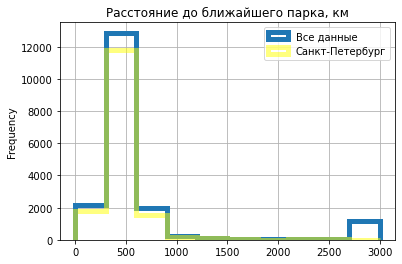

In [81]:
print('Расстояния, \033[1mм\033[0m')
display(round(df[['parks_nearest', 'ponds_nearest',
                'parks_around3000', 'ponds_around3000']].agg(['min', 'mean', 'median', 'max']), 1))

# построим гистограммы расстояний до парков для всех значений,
# затем добавим поверх значения для Санкт-Петербурга
ax_df = df.plot(y='parks_nearest', 
                kind='hist', bins=10, range=(0, 3000),
                figsize=(6,4), histtype='step',
                linewidth=5, label='Все данные');

df.query('locality_name=="Санкт-Петербург"').plot(
                y='parks_nearest', ax=ax_df, grid=True,
                title='Расстояние до ближайшего парка, км',
                kind='hist', bins=10, range=(0, 3000),
                figsize=(6,4), alpha=0.5, histtype='step', color='yellow',
                linewidth=5, label='Санкт-Петербург');

Очевидно, что в этом прекрасном городе много парков :). Более половины всех квартир из нашей базы находятся всего в 500м от ближайшего парка, а приблизительно 8% в непосредственной близости. Справа в небольшом столбике оказались те, у кого до парка больше 3км, причём это в основном квартиры в других населённых пунктах.

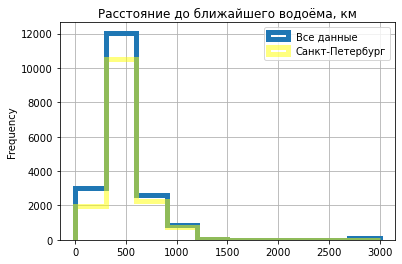

In [82]:
# построим гистограммы расстояний до водоёмов для всех значений,
# затем добавим поверх значения для Санкт-Петербурга
ax_df = df.plot(y='ponds_nearest', 
                kind='hist', bins=10, range=(0, 3000),
                figsize=(6,4), histtype='step',
                linewidth=5, label='Все данные');

df.query('locality_name=="Санкт-Петербург"').plot(
                y='ponds_nearest', ax=ax_df, grid=True,
                title='Расстояние до ближайшего водоёма, км',
                kind='hist', bins=10, range=(0, 3000),
                figsize=(6,4), alpha=0.5, histtype='step', color='yellow',
                linewidth=5, label='Санкт-Петербург');

Гистограммы срисовали друг у друга. Почти те же значения, как и для парков. С той лишь разницей, что водоёмов в этом городе ещё больше, чем парков. Поэтому столбик справа практически исчез. В Санкт-Петербурге сложно найти место, где не было бы рядом воды. 

##### Изучение поля с количеством фотографий 

,total_images
min,0.0
mean,9.8
median,9.0
max,50.0


Количество объявлений без фото:    1054 


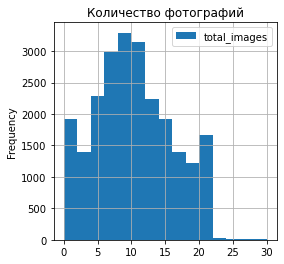

In [83]:
# Выведем основную информацию о количестве фотографий
display(round(df[['total_images']].agg(['min', 'mean', 'median', 'max']), 1))

print('Количество объявлений без фото:   \033[1m', df[df['total_images']==0]['total_images'].count(), '\033[0m')

# построим гистограмму
df.plot(y='total_images', title='Количество фотографий', grid=True, figsize=(4,4),
         kind='hist', bins=15, range=(0, 30));

Максимальное количество фотографий, которое опубликовали клиенты равно 50. Однако на гистограмме резкий спад после 20 изображений. Скорее всего, на сайте есть ограничение по числу фото. Каким образом тогда кто-то мог выложить 50 изображений? Технический сбой или особые клиенты, которым открываются дополнительные возможности например за доплату. А может хакеры тоже продают квартиры 🙂.   

##### Изучение параметров по типу квартиры

Для логических типов данных, определяющих является ли квартира апартаментами, студией или имеет открытую планировку, всё что мы можем выяснить - посчитать сколько их встречается в нашем датафрейме, в том числе по категориям в зависимости от размера квартиры. 

In [84]:
display(pd.DataFrame(df[['is_apartment', 'studio', 'open_plan']].sum(), columns=['total']))

print()
print('Количество квартир разных типов в разных категориях по площади:')
display(df.groupby('total_area_group')[['is_apartment', 'studio', 'open_plan']].sum())

,total
is_apartment,45
studio,149
open_plan,65



Количество квартир разных типов в разных категориях по площади:


,is_apartment,studio,open_plan
total_area_group,,,
0,7,141,58
1,4,4,3
2,13,0,1
3,5,3,2
4,16,1,1


Получается, что апартаменты встречаются чаще в больших по площади квартирах, а студии и квартиры с отрытой планировкой обычно бывают маленькими.

##### День недели, месяц и год публикации объявления

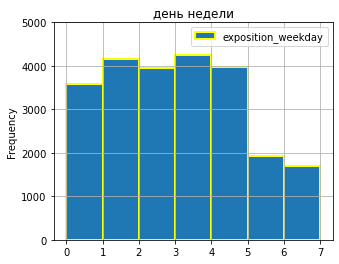

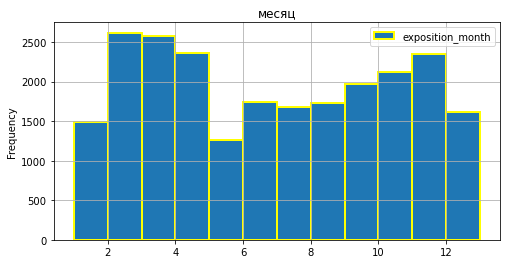

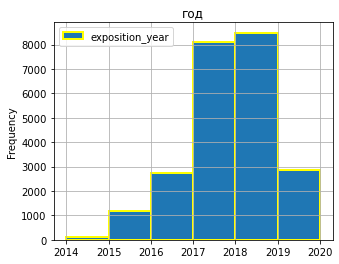

In [85]:
# построим гистограммы для дня недели, месяца и года, когда было опубликовано объявление
df.plot(y='exposition_weekday', title='день недели', 
        grid=True, figsize=(5,4), ec="yellow", lw=2, ylim=(0, 5000),
        kind='hist', bins=7, range=(0, 7));

df.plot(y='exposition_month', title='месяц', 
        grid=True, figsize=(8,4), ec="yellow", lw=2,
        kind='hist', bins=12, range=(1, 13));

df.plot(y='exposition_year', title='год', 
        grid=True, figsize=(5,4), ec="yellow", lw=2,
        kind='hist', bins=6, range=(2014, 2020));

Судя по этим гистограммам, клиенты публиковали объявления по большей части в будние дни. Особенно в четверг или в пятницу, потому что в понедельник у них было гораздо больше важных дел. В выходные они отдыхали :). Или им было удобнее заниматься личными делами, когда они находились на работе. 

Прежде чем рассуждать о гистограмме по месяцам, рассмотрим распределение по годам. Странно низкие значения для 2014 и 2019 года. Убедимся, что это не связанно с неожиданным оттоком клиентов в 2019-ом.

In [86]:
print(f'В таблицах собраны данные за период с \033[1m{df["first_day_exposition"].min():%d.%m.%Y.}\033[0m\
 по \033[1m{df["first_day_exposition"].max():%d.%m.%Y.}\033[0m')

В таблицах собраны данные за период с 27.11.2014. по 03.05.2019.


Значит, страница Яндекс Недвижимости появилась в самом конце 2014 года. Первые два года она постепенно набирала популярность. А выборка наших данных закончилась в начале мая 2019 года. В распределение первые 4 месяца года попадали чаще, чем все остальные. Логичнее будет изучить гистограмму с января 2015 по декабрь 2018. 

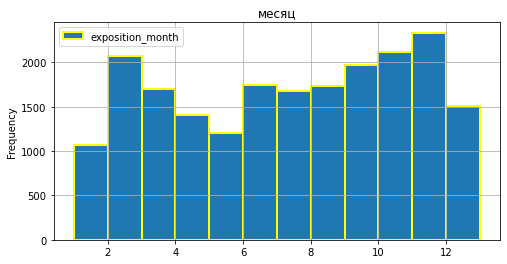

In [87]:
df.query('2014 < exposition_year < 2019').plot(
        y='exposition_month', title='месяц', 
        grid=True, figsize=(8,4), ec="yellow", lw=2,
        kind='hist', bins=12, range=(1, 13));

Картина получилась следующая. Как известно, в январе очень много праздничных дней. Также, как и в субботу и в воскресенье, во время праздников и каникул, публикаций меньше. К февралю клиенты резко просыпаются, выкладывают на сайте все объявления, которые они не выложили в январе. Т.е. если найти среднее между значениями за январь и февраль, то эта величина будет приблизительно такая же, как за март. Весной активность постепенно спадает. В мае тоже много праздничных дней, все готовятся к летнему отдыху. После майских праздников также наблюдается небольшой скачок, но летом всё довольно ровно, значения сравнимы с мартом. После летнего отдыха, количество объявлений на сайте начинает довольно резко расти, пока не достигает своего пика в ноябре. Ближе к концу календарного года люди стараются поскорее завершить все финансовые и прочие дела. Количество опубликованных объявлений в ноябре почти в 2 раза больше, чем в январе или в мае. В декабре, ближе к праздникам наблюдается спад. Многим просто некогда перед Новым годом.

Таким образом, основная причина подобных распределений по дням недели и месяцам года - это выходные и праздничные дни.

##### Насколько быстро продаются квартиры

Вспомним, что во всех случаях, когда количество дней равно нулю, в исходных значениях были пропуски. Мы не знаем, что они означают. Поэтому изучим наш показатель без учёта нулевых значений.

count    20378.0
mean       180.0
std        219.0
min          1.0
25%         45.0
50%         95.0
75%        230.0
max       1580.0
Name: days_exposition, dtype: float64

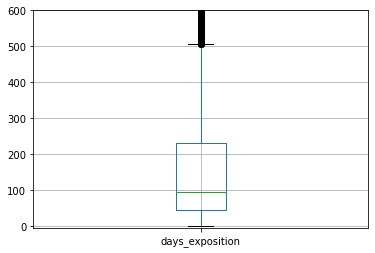

In [88]:
# характерные значения
display(round(df.query('days_exposition>0')["days_exposition"].describe(),0))

# диаграмма размаха
df.query('days_exposition>0').boxplot('days_exposition')
plt.ylim(-5, 600)
plt.show()

По диаграмме размаха видно, что объявления, которые продержались на сайте  больше, чем полтора года (приблизительно) попадают в выбросы. Т.е. это скорее исключения из правил. 

Количество дней наблюдения:  1618 


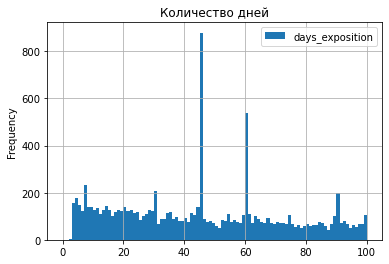

In [89]:
print('Количество дней наблюдения: \033[1m', 
      (df['first_day_exposition'].max() - df['first_day_exposition'].min()).days, '\033[0m')

# построим гистограмму
df.query('days_exposition>0').plot(y='days_exposition', title='Количество дней', grid=True, figsize=(6,4),
         kind='hist', bins=100, range=(0, 100));

Какие интересные пики, которые получились на гистограмме. Они расположились на значениях приблизительно 7, 30, 45, 60, 90. Что бы это значило? Это явно значения "одна неделя", "один месяц", "полтора месяца" и т.д. 

По тому, как ровно распределено количество дней в остальных случаях, это поле скорее всего заполнялось автоматически. Но если бы скорость продажи заполнялась клиентом, то конечно было бы удобнее указывать значение в неделях и месяцах. Причин того, что так получилось, может быть очень много:

- в каких-то случаях клиенты действительно сами заполняли это поле;
- данные собирались из нескольких источников, (например объявление можно было опубликовать на другом сайте с разрешением передать в нашу базу);
- любые технические сбои, когда количество дней в итоге было указано приблизительно;
- поначалу количество дней указывал клиент, а потом рассчеты автоматизировали, ну и т.д.

Можно, конечно, попытаться искать возможные причины, но на наше исследование это никак не повлияет. Проверим сколько записей попало в эти "пиковые" значения: 

In [90]:
print('Количество объявлений, в которых указано 7, 30, 45, 60 и 90 дней: \033[1m', 
      df[df['days_exposition'].isin([7, 30, 45, 60, 90])]['days_exposition'].count(), '\033[0m')

print('Объявлений, которые просуществовали 1 день:\033[1m', 
      df.query('days_exposition==0')['days_exposition'].count(), '\033[0m')

Количество объявлений, в которых указано 7, 30, 45, 60 и 90 дней:  2056 
Объявлений, которые просуществовали 1 день: 3139 


По характерным значениями видно, что в основном клиентам удавалось продать недвижимость месяца за три с небольшим. В редких случаях продажа квартир занимала больше, чем полтора года. Но есть и уникальные объявления, которые ищут своего покупателя более четырёх лет.

Случаев, когда объявление снимают с публикации всего через один день очень много - 13% от всего количества. Но это вовсе не означает, что квартиру так быстро удалось продать. Возможны разные варианты - клиент передумал, решил что-либо исправить (например, изучил цены и обозначил новую сумму), снял публикацию и выложил новое объявление. Как бы ни было, четверть всех объявлений существует не более чем полтора месяца. Т.е. шанс быстро продать квартиру довольно велик.


##### Итоги изучения данных

<div style="text-align: justify; padding: 10px 10px 10px 30px">

Попробуем составить среднестатистическое объявление о продаже недвижимости, которое появилось на сайте в дождливый <font color='#473C8B'>четверг в начале ноября 2018 года</font>. К объявлению прилагалось <font color='#473C8B'>9 фотографий</font>. Квартиру удалось продать к концу января.</div>

<div style="background-color: #F8F8FF; padding: 10px 30px 10px 30px; width: 600px;  height: 100px;
            border: outset; border-color: #473C8B widht=30px">
    
<font color='#473C8B'><b>🏬       Продаётся двухкомнатная квартира на Выборгской стороне.</b></font>
    
Общая площадь 52кв.м (жилая 30, кухня 9, потолки 2,7) на 4 этаже 9-ти этажного дома в 10 минутах ходьбы от парка Сосновка. Начальная цена 4,700,000 руб.   
</div>

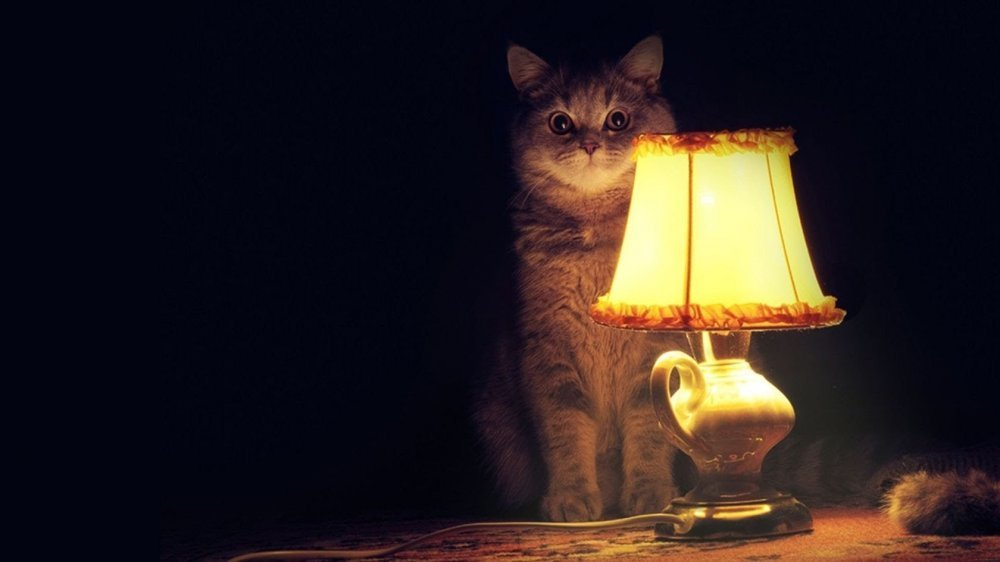

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера__

Я не смог удержаться, после фразы "в дождливый четверг в начале ноября 2018 года".
</div>

#### <font color='#473C8B'>Зависимость цены от различных параметров</font>


В ходе изучения значений цены мы решили, что будем рассматривать только значения ниже 40 миллионов руб. Цены, которые сильно выше уже аномальны 😀. Используем это при рассчете корелляций и построении диаграмм рассеяния.

##### Площадь недвижимости

Чтобы рассмотреть как зависит цена от общей площади, жилой площади и кухни, построим матрицу корелляции для этих величин. В наших данных имелись выбросы - аномально большие цены, более чем в 2 раза превышающие все остальные. Исключим их из нашей выборки для таблицы

In [91]:
# округлим значения до двух знаков после запятой
display(round(df[['price_mln','total_area', 'living_area', 'kitchen_area']].corr(), 2))

,price_mln,total_area,living_area,kitchen_area
price_mln,1.00,0.79,0.70,0.62
total_area,0.79,1.00,0.94,0.61
living_area,0.70,0.94,1.00,0.41
kitchen_area,0.62,0.61,0.41,1.00


В первом столбце увидим насколько зависит цена от площади. Заодно подтвердим наш вывод о том, что жилая площадь напрямую зависит от общей. 

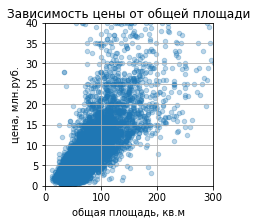

In [92]:
# построим диаграммы рассеивания
df.plot(x='total_area', y='price_mln', title='Зависимость цены от общей площади', 
        xlabel='общая площадь, кв.м', ylabel='цена, млн.руб.', 
        grid=True, figsize=(3,3), alpha=0.3,
        kind='scatter', xlim=(0,300), ylim=(0,40));

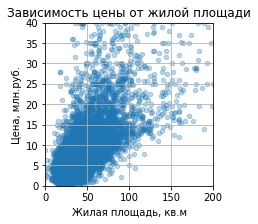

In [93]:
df.plot(x='living_area', y='price_mln', title='Зависимость цены от жилой площади', 
        xlabel='Жилая площадь, кв.м', ylabel='Цена, млн.руб.', 
        grid=True, figsize=(3,3), alpha=0.3,
        kind='scatter', xlim=(0,200), ylim=(0,40));

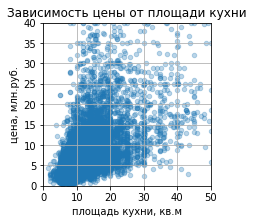

In [94]:
df.plot(x='kitchen_area', y='price_mln', title='Зависимость цены от площади кухни', 
        xlabel='площадь кухни, кв.м', ylabel='цена, млн.руб.', 
        grid=True, figsize=(3,3), alpha=0.3,
        kind='scatter', xlim=(0,50), ylim=(0,40));

Судя по графикам и по матрице корелляции, цена зависит от всех площадей. В особенности - от общей площади. Это и не удивительно - чем больше площадь недвижимости, тем больше её цена. Размеры жилой площади в свою очередь очень сильно зависят от общей (коэффициент корелляции 0.94!). А вот размер кухни - величина чуть более загадочная. От этого показателя цена зависит уже меньше. Также как и кухня меньше зависит от общей площади, чем жилая. 

##### Количество комнат

In [95]:
# Рассчитаем коэффициент корелляции, исключив выбросы в цене
# Заодно убедимся, что количество комнат зависит от площади квартиры
display(round(df[['price_mln','rooms','total_area']].corr(), 2))

,price_mln,rooms,total_area
price_mln,1.00,0.52,0.79
rooms,0.52,1.00,0.79
total_area,0.79,0.79,1.00


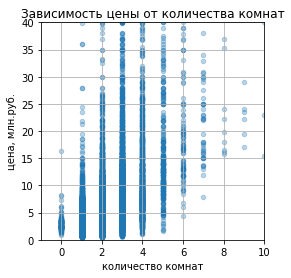

In [96]:
# построим диаграмму рассеивания
df.plot(x='rooms', y='price_mln', title='Зависимость цены от количества комнат', 
        xlabel='количество комнат', ylabel='цена, млн.руб.', 
        grid=True, figsize=(4,4), alpha=0.3,
        kind='scatter', xlim=(-1,10), ylim=(0,40));

Какая-то слабая получилась зависимость. Но всё же там где 0 комнат больших цен нет, а самые дорогие сосредоточились для 4-5 комнат. Можно утверждать, что количество комнат в квартире очень слабо влияет на цену. Видимо потому что в больших квартирах могут быть большие по размеру комнаты. Поэтому столбец для 3-х комнатных квартир проходит по всей диаграмме снизу вверх. Внизу - обычные трёхкомнатные за относительно небольшую цену, а сверху - те же пентхаузы, где 3 огромных комнаты.

##### Высота потолков

In [97]:
# Рассчитаем коэффициент корелляции, исключив выбросы в цене
display(round(df[['price_mln','ceiling_height']].corr(), 2))

,price_mln,ceiling_height
price_mln,1.00,0.49
ceiling_height,0.49,1.00


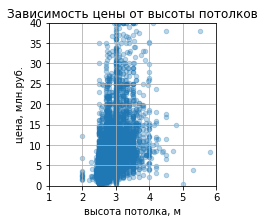

In [98]:
# построим диаграмму рассеивания
df.plot(x='ceiling_height', y='price_mln', title='Зависимость цены от высоты потолков', 
        xlabel='высота потолка, м', ylabel='цена, млн.руб.', 
        grid=True, figsize=(3,3), alpha=0.3,
        kind='scatter', xlim=(1,6), ylim=(0,40));

Картинка такая же, как для количества комнат. Только там значения дискретные и график там выглядит как столбики. Наш ответ: на высоту потолков при выборе квартиры обращают внимание далеко не в первую очередь и на цену этот параметр влияет слабо. 

##### Этажи

In [99]:
# Рассчитаем коэффициент корелляции, исключив выбросы в цене
display(round(df[['price_mln','floor', 'floors_total']].corr(), 2))

,price_mln,floor,floors_total
price_mln,1.00,0.06,0.05
floor,0.06,1.00,0.68
floors_total,0.05,0.68,1.00


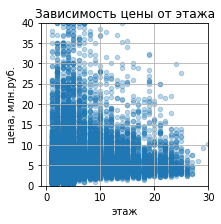

In [100]:
# построим диаграмму рассеивания
df.plot(x='floor', y='price_mln', title='Зависимость цены от этажа', 
        xlabel='этаж', ylabel='цена, млн.руб.', 
        grid=True, figsize=(3,3), alpha=0.3,
        kind='scatter', xlim=(-1,30), ylim=(0,40));

Вот как выглядит почти нулевая корелляция на диаграмме рассеяния. Все точки сосредоточились внизу. Цена практически не зависит ни от этажа, ни от этажности дома. Хотя можно смело утверждать, что дорогие квартиры редко продаются выше 10 этажа. Возможно дело в том, что в центре Санкт-Петербурга не очень много высоких домов. А квартиры там наверняка дороже (мы это ещё проверим). 

Но у нас остался ещё один параметр - тип этажа. 

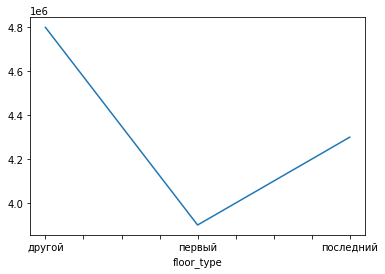

In [101]:
df.groupby('floor_type')['last_price'].median().plot();

Небольшие (если их можно так назвать!) цены есть в любых категориях. Но зависимость всё же прослеживается. На первом этаже недвижимость стоит чуть дешевле, чем посередине здания или тем более на верхних этажах. На крыше жильё часто бывает самым дорогим. Мы видели строки в нашей таблице, которые явно относятся к пентхаузам. 

In [102]:
print('Cреднее значение и медиана цены в зависимости от типа этажа, млн.руб.')
# создадим табличку с медианами
floors_df = df.pivot_table(index='floor_type', values=['price_mln'], aggfunc=['mean', 'median']).reset_index()
floors_df.columns = ['floor_type', 'mean', 'median']

# добавим строку для всех значениий
floors_df.loc[len(floors_df)] = ['все этажи', 
                                 df['price_mln'].mean(), df['price_mln'].median()]

# выведем на экран
display(floors_df.style.format('{:0.3}', subset=['median','mean']).\
        background_gradient('Blues', subset='median'))

Cреднее значение и медиана цены в зависимости от типа этажа, млн.руб.


,floor_type,mean,median
0,другой,6.15,4.8
1,первый,4.61,3.9
2,последний,5.81,4.3
3,все этажи,5.91,4.6


Недвижимость на первом этаже стоит в среднем на 16% дешевле по сравнению с медианой цены по всем данным. 
На последних этажах жильё тоже дешевле, но в меньшей степени (приблизительно на 7%). Проверим, существует ли 
такая же зависимость в разных по площади квартирах. Сгруппируем данные в зависимости от категории квартир по площади.

In [103]:
# создадим еще одну сводную таблицу с медианами цены 
# в разных типах квартир по категориям в зависимости от площади
floors_area_df = df.pivot_table(index='floor_type', columns='total_area_group', 
                values='price_mln', aggfunc='median').reset_index()

# добавим строку для всех значениий
floors_area_df.loc[len(floors_area_df)] = ['все этажи'] + \
        df.groupby('total_area_group')['price_mln'].median().to_list()

display(floors_area_df.style.highlight_max(color='lightblue', subset=[0,1,2,3,4]).\
       format('{:0.3}', subset=[0,1,2,3,4]))     

total_area_group,floor_type,0,1,2,3,4
0,другой,3.29,4.1,4.9,6.1,10.4
1,первый,2.75,3.4,4.0,5.0,7.8
2,последний,2.95,3.6,4.3,5.3,10.5
3,все этажи,3.19,3.95,4.7,5.89,10.0


Найденная нами зависимость совсем незначительно нарушается в случае больших по площади 
квартир на верхних этажах. Такое жильё стоит, как правило, немного дороже, чем обычные квартиры.

##### Наличие балконов

Раз уж мы убирали в этом столбце пропуски, изучали значения, получим хоть какую-то информацию про балконы дополнительно. Мы заменили пропущенные значения нулями, заменили на 1 значения, где балконов было слишком много. Поэтому нет смысла искать зависимость от количества. Проверим, не влияет ли наличие балконов ну например на медиану от цены. 

In [104]:
print('Медиана цены (в млн.руб.)')
print('по всем данным:\033[1m', 
      df['price_mln'].median(), '\033[0m')
print('для квартир, где балконов нет или нет о них информации:\033[1m', 
      df.query('balcony==0')['price_mln'].median(), '\033[0m')
print('для квартир, где есть балконы:\033[1m', 
      df.query('balcony>0')['price_mln'].median(), '\033[0m')

Медиана цены (в млн.руб.)
по всем данным: 4.6 
для квартир, где балконов нет или нет о них информации: 4.6 
для квартир, где есть балконы: 4.6 


~Средняя температура по больнице~ Информация о балконах нужна для покупателей недвижимости, но на цену она не влияет. Надо было сразу удалить весь столбец 🙄

##### День недели, месяц и год

In [105]:
# Рассчитаем коэффициент корелляции, исключив выбросы в цене
display(round(df[['price_mln','exposition_weekday', 
                                       'exposition_month', 'exposition_year']].corr(), 2))

,price_mln,exposition_weekday,exposition_month,exposition_year
price_mln,1.00,-0.01,0.00,-0.04
exposition_weekday,-0.01,1.00,0.01,-0.00
exposition_month,0.00,0.01,1.00,-0.27
exposition_year,-0.04,-0.00,-0.27,1.00


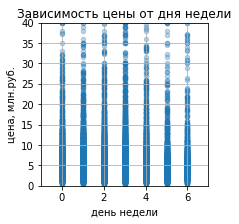

In [106]:
# построим диаграмму рассеивания
df.plot(x='exposition_weekday', y='price_mln', title='Зависимость цены от дня недели', 
        xlabel='день недели', ylabel='цена, млн.руб.', 
        grid=True, figsize=(3,3), alpha=0.3,
        kind='scatter', xlim=(-1,7), ylim=(0,40));

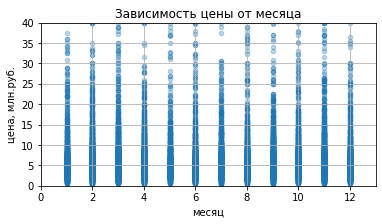

In [107]:
# построим диаграмму рассеивания
df.plot(x='exposition_month', y='price_mln', title='Зависимость цены от месяца', 
        xlabel='месяц', ylabel='цена, млн.руб.', 
        grid=True, figsize=(6,3), alpha=0.3,
        kind='scatter', xlim=(0,13), ylim=(0,40));

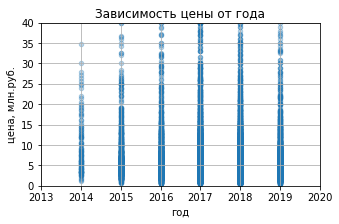

In [108]:
# построим диаграмму рассеивания
df.plot(x='exposition_year', y='price_mln', title='Зависимость цены от года', 
        xlabel='год', ylabel='цена, млн.руб.', 
        grid=True, figsize=(5,3), alpha=0.3,
        kind='scatter', xlim=(2013,2020), ylim=(0,40));

Корелляция равна нулю. Цена абсолютно никак не зависит ни от дня недели, ни от месяца, ни от года. В столбцах графика для  воскресенья и января немного меньше точек исключительно потому что в это время объявлений публикуется значительно меньше.

##### Количество фотографий

In [109]:
# Рассчитаем коэффициент корелляции, исключив выбросы в цене
display(round(df[['price_mln','total_images']].corr(), 2))

,price_mln,total_images
price_mln,1.00,0.15
total_images,0.15,1.00


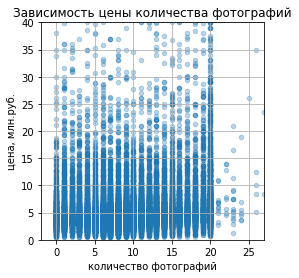

In [110]:
# построим диаграмму рассеивания
df.plot(x='total_images', y='price_mln', title='Зависимость цены количества фотографий', 
        xlabel='количество фотографий', ylabel='цена, млн.руб.', 
        grid=True, figsize=(4,4), alpha=0.3,
        kind='scatter', xlim=(-2,27), ylim=(0,40));

Интересный пик там, где 20 изображений. Похоже, что на самом деле это максимальное количество, которое можно выложить на сайте, потому что дальше в диаграмме попадаются только редкие точки. При этом даже отсутствие изображений не мешает успешно продавать недвижимость. 

##### Тип квартиры

В ходе изучения полей, где указаны апартаменты, студии и квартиры со свободной планировкой, мы выяснили, что апартаменты чаще всего встречаются в больших квартирах (это категория 4 по площади), а студии и квартиры со свободной планировкой - в самых маленьких квартирах (категория 0). Квартир таких ничтожно мало по сравнению со всем количеством данных нашей таблицы. 

Не станем чертить графики. Посупим также, как с балконами. Просто посчитаем медианы для сравнения. Только для апартаментов это будут медианы в категории самых больших по площади квартир, а для студий и свободной планировки - в категории самых тесных квартир.

In [111]:
# создадим небольшую табличку с медианами
# хотела сделать с помощью pivot_table, но именно в таком виде не получилось
flat_type = pd.DataFrame([True, False, 'category'], columns=['value'])

flat_type['is_apartment (4)'] = [df.query('total_area_group==4 & is_apartment')['price_mln'].median(), 
                             df.query('total_area_group==4 & ~is_apartment')['price_mln'].median(),
                             df.query('total_area_group==4')['price_mln'].median()]
flat_type['studio (0)'] = [df.query('total_area_group==0 & studio')['price_mln'].median(), 
                       df.query('total_area_group==0 & ~studio')['price_mln'].median(),
                       df.query('total_area_group==0')['price_mln'].median()]
flat_type['open_plan (0)'] = [df.query('total_area_group==0 & open_plan')['price_mln'].median(), 
                          df.query('total_area_group==0 & ~open_plan')['price_mln'].median(), 
                          df.query('total_area_group==0')['price_mln'].median()]

print('Медианы цены в млн.руб.')
display(flat_type)

Медианы цены в млн.руб.


,value,is_apartment (4),studio (0),open_plan (0)
0,True,9.77,2.70,2.60
1,False,10.05,3.20,3.20
2,category,10.02,3.19,3.19


В верхней строке - медианы цены для указанных сверху квартир. В скобках - номер категории по площади квартиры. В нижней строке - медианы для всей группы. Получается, что цена на апартаменты, на студии и на квартиры со свободной планировкой ниже, чем цены похожих по площади квартир. Для апартаментов разница незначительная. Они дешевле остальных квартир своей категории в среднем на 2.3%. А вот студии и квартиры со свободной планировкой довольно сильно отличаются - на 16% и 19% соответственно от своих "соседей" по категории.

##### Расстояния

Так как в Ленинградской области есть и города, и посёлки, а в базе данных есть объявления о продаже недвижимости и в  огромных квартирах в центре города, и в садовых товариществах - нет смысла сравнивать зависимость расстояний от центра города для всех данных. Поэтому это исследование проведём только для Санкт-Петербурга.

In [112]:
# Рассчитаем коэффициент корелляции, исключив выбросы в цене
display(round(df.query('locality_name=="Санкт-Петербург"')\
              [['price_mln','center_distance', 'airport_distance']].corr(), 2))

,price_mln,center_distance,airport_distance
price_mln,1.00,-0.41,-0.01
center_distance,-0.41,1.00,0.17
airport_distance,-0.01,0.17,1.00


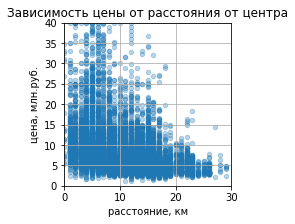

In [113]:
# построим диаграммы рассеивания
df.query('locality_name=="Санкт-Петербург"').plot(
        x='center_distance', y='price_mln', title='Зависимость цены от расстояния от центра', 
        xlabel='расстояние, км', ylabel='цена, млн.руб.', 
        grid=True, figsize=(3,3), alpha=0.3,
        kind='scatter', xlim=(0,30), ylim=(0,40));

Судя по коэффициенту корелляции, цена от расстояния от почти не завит. А судя по диаграмме явно прослеживается очевидный факт - чем ближе к центру города, тем больше дорогих квартир. Учитывая географию Санкт-Петербурга, исторический центр занимает довольно большую площадь. Поэтому все данные в радиусе 5 км можно считать центром. 

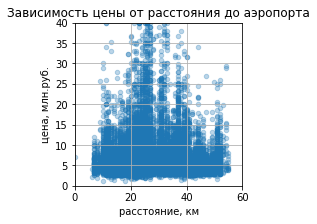

In [114]:
df.query('locality_name=="Санкт-Петербург"').plot(
        x='airport_distance', y='price_mln', title='Зависимость цены от расстояния до аэропорта', 
        xlabel='расстояние, км', ylabel='цена, млн.руб.', 
        grid=True, figsize=(3,3), alpha=0.3,
        kind='scatter', xlim=(0,60), ylim=(0,40));

Расстояние до аэропорта не влияет на цену. Зато по картинке видно, что центр города находится приблизительно в 25 км от аэропорта.

##### Близость к паркам и водоёмам

In [115]:
# Рассчитаем коэффициент корелляции, исключив выбросы в цене
display(round(df.query('locality_name=="Санкт-Петербург"')\
              [['price_mln','parks_nearest', 'ponds_nearest']].corr(), 2))

,price_mln,parks_nearest,ponds_nearest
price_mln,1.00,0.02,-0.10
parks_nearest,0.02,1.00,-0.02
ponds_nearest,-0.10,-0.02,1.00


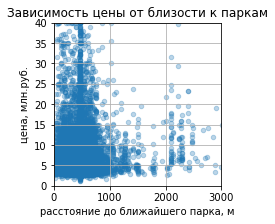

In [116]:
# построим диаграммы рассеивания
df.query('locality_name=="Санкт-Петербург"').plot(
        x='parks_nearest', y='price_mln', title='Зависимость цены от близости к паркам', 
        xlabel='расстояние до ближайшего парка, м', ylabel='цена, млн.руб.', 
        grid=True, figsize=(3,3), alpha=0.3,
        kind='scatter', xlim=(0,3000), ylim=(0,40));

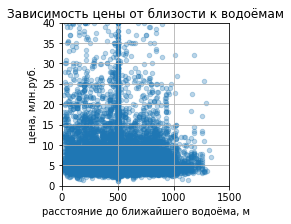

In [117]:
df.query('locality_name=="Санкт-Петербург"').plot(
        x='ponds_nearest', y='price_mln', title='Зависимость цены от близости к водоёмам', 
        xlabel='расстояние до ближайшего водоёма, м', ylabel='цена, млн.руб.', 
        grid=True, figsize=(3,3), alpha=0.3,
        kind='scatter', xlim=(0,1500), ylim=(0,40));

Также как и в случае с балконами, вряд ли эти данные, от которых ни цена, ни скорость продажи квартир не зависят, принесут нам какую-либо пользу.

#### <font color='#473C8B'>Зависимость скорости продажи от основных параметров</font>

Проверим такую зависимость только от площади квартир и от расстояния до центра и только для Санкт-Петербурга, где рынок недвижимости более активный, чем в небольших посёлках.

In [118]:
# Рассчитаем коэффициент корелляции, исключив выбросы в цене
display(round(df[['total_images', 'days_exposition','total_area', 'price_mln']].corr(), 2))

,total_images,days_exposition,total_area,price_mln
total_images,1.00,-0.06,0.11,0.15
days_exposition,-0.06,1.00,0.10,0.07
total_area,0.11,0.10,1.00,0.79
price_mln,0.15,0.07,0.79,1.00


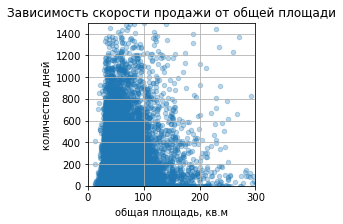

In [119]:
# построим диаграммы рассеивания
df.plot(x='total_area', y='days_exposition', title='Зависимость cкорости продажи от общей площади', 
        xlabel='общая площадь, кв.м', ylabel='количество дней', 
        grid=True, figsize=(3,3), alpha=0.3,
        kind='scatter', xlim=(0,300), ylim=(0,1500));

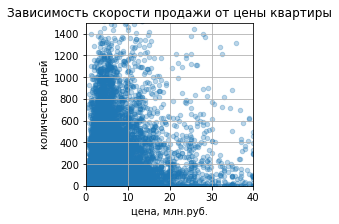

In [120]:
df.plot(x='price_mln', y='days_exposition', title='Зависимость cкорости продажи от цены квартиры', 
        xlabel='цена, млн.руб.', ylabel='количество дней', 
        grid=True, figsize=(3,3), alpha=0.3,
        kind='scatter', xlim=(0,40), ylim=(0,1500));

Какие одинаковые графики! Опять мы проверили очевидный факт. Корелляция очень маленькая и для площади, и для цены. Видимо на скорость продажи влияют другие факторы.

#### <font color='#473C8B'>Средняя цена одного квадратного метра</font>

Выполним рассчеты для 10 населённых пунктов с наибольшим числом объявлений. В случае Санкт-Петербурга следует иметь ввиду, что разброс цен на недвижимость здесь огромный. Выбросов тоже довольно много. Поэтому даже если отсечь квартиры дороже 40млн.руб., среднее значение будет не характерным. Поэтому лучше рассчитать и среднее значение, и медиану.
Сначала найдем где больше всего квартир выставляется на продажу.

In [121]:
# сохраним 10 названий в список, воспользовавшись услугой value_counts
city_list = df['locality_name'].value_counts()[0:10].index.to_list()
display(city_list)

['Санкт-Петербург',
 'Мурино',
 'Кудрово',
 'поселок Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'поселок Парголово',
 'Гатчина',
 'Выборг']

In [122]:
# создадим сводную таблицу, куда внесём средние значения и медианы цены за кв.м
top_df = df[df['locality_name'].isin(city_list)].pivot_table(
            index='locality_name', values='price_per_meter', aggfunc=('mean', 'median')).reset_index()

# округлим до целого средние значения
top_df['mean'] = round(top_df['mean'], 0)
# отсортируем по убыванию средней цены
top_df = top_df.sort_values(by='mean', ascending=False).reset_index(drop=True)
top_df

,locality_name,mean,median
0,Санкт-Петербург,111665.0,104412.0
1,Пушкин,103101.0,99993.5
2,Кудрово,95325.0,95675.5
3,поселок Парголово,90176.0,91643.0
4,Мурино,86088.0,86175.5
5,поселок Шушары,78677.0,76876.0
6,Колпино,75425.0,74723.5
7,Гатчина,68746.0,67797.0
8,Всеволожск,68654.0,65789.0
9,Выборг,58142.0,58158.0


В этой таблице - не обязательно самые "дорогие" города Ленинградской области. Мы же делали выборку только среди 10 населённых пунктов с самым большим количеством объявлений.

In [123]:
print('Средняя цена за 1кв.м жилья:')
print('- самая высокая - в населённом пункте:\033[1m', 
      df.groupby('locality_name')['price_per_meter'].mean().idxmax(), 
      '\033[0m составляет: \033[1m', 
      round(df.groupby('locality_name')['price_per_meter'].mean().max(), 0), 
      '\033[0mруб.')
print('- самая низкая - в населённом пункте:\033[1m', 
      df.groupby('locality_name')['price_per_meter'].mean().idxmin(), 
      '\033[0m  составляет:\033[1m', 
      round(df.groupby('locality_name')['price_per_meter'].mean().min(), 0), 
      '\033[0mруб.')
print()
print('Медиана цены за 1кв.м жилья:')
print('- самая высокая - в населённом пункте:\033[1m', 
      df.groupby('locality_name')['price_per_meter'].median().idxmax(), 
      '\033[0m  составляет:\033[1m', 
      round(df.groupby('locality_name')['price_per_meter'].median().max(), 0), 
      '\033[0mруб.')
print('- самая низкая - в населённом пункте:\033[1m', 
      df.groupby('locality_name')['price_per_meter'].median().idxmin(), 
      '\033[0m  составляет:\033[1m', 
      round(df.groupby('locality_name')['price_per_meter'].median().min(), 0), 
      '\033[0mруб.')

Средняя цена за 1кв.м жилья:
- самая высокая - в населённом пункте: Зеленогорск  составляет:  115123.0 руб.
- самая низкая - в населённом пункте: деревня Старополье   составляет: 11206.0 руб.

Медиана цены за 1кв.м жилья:
- самая высокая - в населённом пункте: Санкт-Петербург   составляет: 104412.0 руб.
- самая низкая - в населённом пункте: деревня Старополье   составляет: 11000.0 руб.


Вот оно как! А мы-то думали, что в первой строке лидеров всегда Санкт-Петербург. В Зеленогорске на берегу Финского залива гораздо лучше. 

#### <font color='#473C8B'>Средняя цена каждого километра от центра для Санкт-Петербурга</font>

In [124]:
# сделаем срез данных для Санкт-Петербурга, куда включим столбцы 
# с ценой (в млн.руб.), ценой за 1 кв.м и расстоянием от центра
spb_df = df.query('locality_name=="Санкт-Петербург"')[[
    'center_distance', 'price_mln', 'price_per_meter']]

# цена за 1 кв.м посчитана в рублях. Переведём её в тысячи
spb_df['price_per_meter'] /= 1000

# центр города - понятие растяжимое. Чтобы не делить на ноль - исправим нули на 1
spb_df['center_distance'] = spb_df['center_distance'].mask(spb_df['center_distance']==0, 1)

# теперь в столбце нет пропущенных и нулевых значений, присвоим целочисленный тип
spb_df['center_distance'] = spb_df['center_distance'].astype(int)

# добавим столбец с ценой за километр для каждой квартиры
spb_df['price_per_km'] = round(spb_df['price_mln'] / spb_df['center_distance'], 3)

print()
print('Количество объектов недвижимости из Санкт-Петербурга в базе данных:\033[1m', 
      len(spb_df), '\033[0m')
print('Медиана цены за 1 километр расстояния от центра:\033[1m', 
      1000000*spb_df['price_per_km'].median(), '\033[0mруб.')

print('Матрица корелляции для определения зависимости цен от расстояния от центра:')
display(round(spb_df[['price_mln', 'price_per_km', 'price_per_meter', 'center_distance']].corr(), 2))


Количество объектов недвижимости из Санкт-Петербурга в базе данных: 15577 
Медиана цены за 1 километр расстояния от центра: 446000.0 руб.
Матрица корелляции для определения зависимости цен от расстояния от центра:


,price_mln,price_per_km,price_per_meter,center_distance
price_mln,1.00,0.64,0.62,-0.41
price_per_km,0.64,1.00,0.44,-0.55
price_per_meter,0.62,0.44,1.00,-0.33
center_distance,-0.41,-0.55,-0.33,1.00


Расстояние от центра города безусловно влияет на цену недвижимости, но чуть меньше, чем площадь квартир. Значения корелляции для расстояния отрицательные, так как с увеличением этого значения, цены уменьшаются.

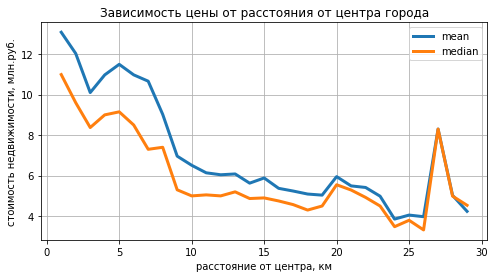

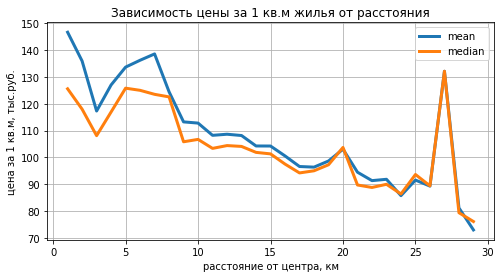

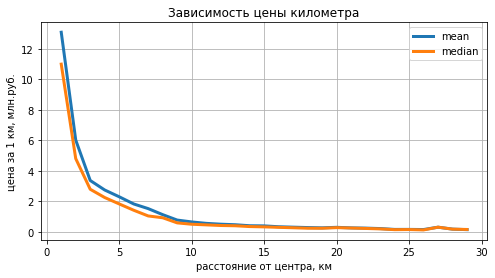

In [125]:
# создадим сводную таблицу с медианами и средним от цены за 1 км
# и на её основе построим график
spb_df.pivot_table(index='center_distance', 
                   values='price_mln', aggfunc=('median', 'mean')).reset_index().plot(
        x='center_distance', y=['mean', 'median'],
        xlabel='расстояние от центра, км', 
        ylabel='стоимость недвижимости, млн.руб.', 
        title='Зависимость цены от расстояния от центра города', 
        grid=True, figsize=(8,4), linewidth=3);

# создадим сводную таблицу с медианами и средним от цены за 1 кв.м 
# и на её основе построим график
spb_df.pivot_table(index='center_distance', 
                   values='price_per_meter', aggfunc=('median', 'mean')).reset_index().plot(
        x='center_distance', y=['mean', 'median'],
        xlabel='расстояние от центра, км', 
        ylabel='цена за 1 кв.м, тыс.руб.', 
        title='Зависимость цены за 1 кв.м жилья от расстояния', 
        grid=True, figsize=(8,4), linewidth=3);


# создадим сводную таблицу с медианами и средним от цены за 1 км
# и на её основе построим график
spb_df.pivot_table(index='center_distance', 
                   values='price_per_km', aggfunc=('median', 'mean')).reset_index().plot(
        x='center_distance', y=['mean', 'median'],
        xlabel='расстояние от центра, км', 
        ylabel='цена за 1 км, млн.руб.', 
        title='Зависимость цены километра', 
        grid=True, figsize=(8,4), linewidth=3);

Зависимость цены от расстояния не совсем линейная величина. Скорее всего, влияние оказывают также различные районы города. Например, пик в конце наших графиков с большей долей вероятности - элитная недвижимость на берегу Финского залива, как раз приблизительно в 25-27 км от центра города. Самые дорогие квартиры, конечно в центре и рядом. 


#### <font color='#473C8B'>Выводы по итогам исследования данных</font>

<div style="text-align: justify; padding: 10px 10px 10px 30px">
В ходе изучения влияния различных параметров на цену недвижимости установлено следующее:
    <p></p>    
    
Влияние на цену оказывает:
    
- __Площадь__. Стоимость квартир растёт в зависимости от их площади. Причём размеры жилой площади напрямую связаны с размерами общей площади. Тогда как размер кухни гораздо меньше зависит от размеров квартиры и оказывает меньшее влияние на цену. Так как все три величины - общая, жилая и площадь кухни связаны между собой, нет смысла рассматривать их по-отдельности. Среди всех изученных параметров общая площадь имеет наибольший коэффициент корелляции cо стоимостью недвижимости (0.79).
    

Слабо влияют на цену:
    
- __Количество комнат__. От этого параметра стоимость недвижимости зависит гораздо слабее (коэффициент корелляции 0.52). Количество комнат, хотя и связано с площадью квартиры, далеко не всегда бывает большим для недвижимости с большой площадью. Так, количество трёхкомнатных квартир приблизительно одинаково для всех уровней цен и для разных по площади квартир. 

    
- __Высота потолков__. Приблизительно так же влияет на стоимость, как и количество комнат (0.49). Учитывая что около 39% всех данных не содержало информации о высоте потолков, а в имеющихся данных было довольно много аномальных и неверно указанных значений, не следует сильно полагаться на этот параметр. 
    

- __Расстояние от центра__. Хотя неоспорим тот факт, что самая дорогая недвижимость находится в центре, корелляция этой величины по отношению к цене даже меньше, чем у параметра высоты потолков и составляет 0.41. Влияние расстояния от центра на стоимость недвижимости рассматривалась только для Санкт-Петербурга, так как картографические данные большинства населённых пунктов отсутствовали. В целом, цена постепенно уменьшается при удалении от центра, но зависит она скорее от района города. И на переферии также есть дорогая недвижимость. На значение расстояния от центра следует опираться, если рассматривать не полную стоимость, а цену за 1 кв.м площади или за километр расстояния от центра.
    

Не влияют напрямую:
    

- __Тип этажа квартиры__. Цена абсолютно не зависит ни от номера этажа, ни от этажности здания. В этом случае важно только является ли этаж первым или последним (верхним) этажом. Цены на недвижимость на первых этажах - приблизительно на 16% ниже обычных цен. Квартиры на верхних этажах также стоят дешевле, но не настолько сильно. Причём в категории самых больших по площади квартир, цена жилья на верхних этажах сравнима со средними значениями за счёт наличия на рынке элитной недвижимости на верхних этажах зданий. 

    
- __Тип квартиры__. Доля апартаментов, студий и квартир с открытой планировкой на рынке ничтожно мала - они составляют всего 1% от всех объектов недвижимости. Но апартаменты встречаются по большей части среди квартир с большой площадью. И в этой категории цена на апартаменты в среднем незначительно (на 2.3%), но ниже чем обычно. Студии и квартиры с открытой планировкой чаще принадлежат к группе самых маленьких по площади квартир. И внутри своей категории их средняя цена ниже приблизительно на 16% и 19% соответственно по сравнению со средними ценами в категории.
    

Не влияют или почти не влияют на цену:
    
- количество фотографий;
- наличие балконов;
- день, месяц и год публикации объявления;
- парки и водоёмы поблизости;
- расстояние от аэропорта.   
    

Также рассмотрены:
    
- __Цена 1кв.м площади__. Имеет более выраженную зависимость от расстояния от центра города, чем просто стоимость недвижимости. Имеет коэффициент корелляции с расстоянием 0.62 (по сравнению с 0.41 для стоимости). Самая высокая средняя цена за 1кв.м жилья (среди десяти населенных пунктов с наибольшим количеством объявлений) в Зеленогорске составляет чуть больше 115 тыс.руб., самая высокая медиана цены - в Санкт-Петербурге: <b>104.4 тыс.руб.</b> Из всех данных самое дешевое жильё находится в деревне Старополье.
    

- __Цена 1 километра__. Вычислены медианы цен для каждого километра от центра. Медиана медиан для города, проще говоря, средняя стоимость 1 километра расстояния <b>446 тыс.руб</b>.
    

- __Скорость продажи квартир__. В основном клиентам удавалось продать недвижимость за три с небольшим месяца. Самыми долгими можно считать случаи, когда квартира ждала покупателя 4 с лишним года. Случаев, когда объявление снимали с публикации всего через один день - 13% от всего количества. Но это вовсе не означает, что квартиру так быстро удалось продать. Возможно клиент передумал, решил что-либо исправить и т.п. Как бы ни было, четверть всех объявлений существует не более чем полтора месяца. Т.е. шанс быстро продать квартиру довольно велик.
    
</div>

### Общий вывод

#### Параметры для отслеживания аномальных значений цены


- В качестве определяющего параметра для стоимости недвижимости лучше всего рассматривать __общую площадь__. Чем больше площадь квартиры, тем больше её цена. 


- Удобнее всего рассмотреть влияние __расстояния от центра__ на __стоимость 1 кв.м площади__. Но при этом необходимо учесть, что цена за 1кв.м может имеет значительные колебания в зависимости от районов города. Как вариант - кроме центра города можно выделить несколько маленьких центров, поблизости от которых будет происходить увеличение цены (а может и сильное уменьшение, если в есть "неблагополучные" районы). Если составить такую "карту" цен, то можно попытаться отследить аномально высокие или низкие значения по разным категориям недвижимости одного района.


- Если есть возможность рассчитать __среднюю цену 1 километра__ расстояния от центра, то для недвижимости, расположенной близко к центру, можно опираться на значения этих средних величин. Но чем дальше расположение от центра, тем более "одинаковым" будет становиться этот параметр.


- Следует учесть, что сильно уменьшат цену такие факты, как __первый этаж__ (приблизительно на 16% от средней цены), __верхний этаж__ (приблизительно на 7%), кроме случаев, когда квартира занимает большую площадь на верхнем этаже. 


- Отрицательное влияние на цену будут также иметь __студии__ и __квартиры с открытой планировкой__ (уменьшат стоимость приблизительно на 16 и 19% соответственно) и незначительно - __апартаменты__.


- Количество комнат, высота потолков, если и влияют на цену, то не ясно, как логичным образом можно отследить такую зависмость. 

#### Способы не допустить ошибочных значений в объявлениях


Чтобы исключить появление аномальных данных, можно рекомендовать включить проверку при публикации объявления:

- общая площадь квартиры должна быть не меньше суммы жилой площади и кухни;

- в случае, если для недвижимости указано ненулевое количество комнат, не должны получиться комнаты слишком маленького размера (в расчёте от жилой или общей площади);

- следует установить ограничение на разумную высоту потолков помещения;

- надеюсь, определение населённого пункта по карте тоже уже доступно :))


#### Возможные способы не допустить мошеннических действий при публикации объявлений


В данных были обнаружены очень похожие, но не полностью совпадающие записи. Самый интересный пример:  когда полностью совпали все данные (включая дату, количество фотографий и т.п), кроме населённого пункта. По теории вероятности - это вообще небывалый случай. 

В связи с этим можно рекомендовать добавить проверку данных в момент публикации объявления или после, но на регулярной основе на совпадения большого количества полей. Например, если в 9 из 10 значимых столбцов у двух или более записей все значения одинаковы. 

#### Прочие обнаруженные особенности, которые можно использовать

Было замечено, что по выходным дням и в предверии новогодних праздников, количество публикуемых объявлениий снижается. В тех случаях, когда необходимо провести какие-либо технические работы на сайте, кроме ночного времени, которое обычно используется, можно делать это в выходные. И пусть простят меня те, кому придется в выходны работать:)))
